<h1><center>Predicting Outcomes of US Supreme Court Oral Arguments</center></h1>
<h1 style="margin-top: -15px; margi-bottom: 10px;"><center>Final Report</center></h1>

## Project and Team Information
**Team members:** Federico Dominguez, Jessup Jong, Chanteria Milner, and Michael Plunkett \
**Project repository:** [Link](https://github.com/michplunkett/supreme-court-ml-predictions) \
**Project information:** The project uses historic United States Supreme Court cases to train natural language processing models to predict case rulings. 

## Setup

In [1]:
# Import the necessary packages
from IPython.display import Markdown
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

from supreme_court_predictions.summary_analysis.descriptive_statistics import (
    DescriptiveStatistics,
)
from supreme_court_predictions.models.logistic_regression import (
    LogisticRegression,
)
from supreme_court_predictions.models.random_forest import RandomForest
from supreme_court_predictions.models.simulation import Simulation
from supreme_court_predictions.models.xg_boost import XGBoost
from supreme_court_predictions.util.functions import get_full_data_pathway

%load_ext jupyter_black
%matplotlib inline

In [2]:
# Setup the necessary datasets
LABELS = np.array(["for respondent", "for petitioner"])

# Loading unprocessed dataframes
data_path = get_full_data_pathway("clean_convokit/")
utterances = pd.read_csv(data_path + "utterances_df.csv")
advocates = pd.read_csv(data_path + "advocates_df.csv")
cases = pd.read_csv(data_path + "cases_df.csv")
conversations = pd.read_csv(data_path + "conversations_df.csv")
speakers = pd.read_csv(data_path + "speakers_df.csv")
voters = pd.read_csv(data_path + "voters_df.csv")

# Loading processed dataframes
proc_data_path = get_full_data_pathway("processed/")
cases_proc = pd.read_pickle(proc_data_path + "case_aggregations.p")
judges_proc = pd.read_pickle(proc_data_path + "judge_aggregations.p")
adversary_proc = pd.read_pickle(proc_data_path + "adversary_aggregations.p")
advocate_proc = pd.read_pickle(proc_data_path + "advocate_aggregations.p")

# Load descriptive statistics
ds = DescriptiveStatistics()
ds.parse_all_data()

In [3]:
# Helper Functions
def dict_to_df(column_names, dict1, dict2=None, dict3=None):
    """
    Transforms a dictionary to a dataframe for better presentation.

    :param column_names (list): List of column names for dataframe.
    :param dict1 (dictionary): Dictionary of data to convert.
    :param dict2 (dictionary, optional): Dictionary of data to convert.
    :param dict3 (dictionary, optional): Dictionary of data to convert.
    : return (DataFrame) DataFrame representation of dictionary.
    """

    df = {
        column_names[0]: list(dict1.keys()),
        column_names[1]: list(dict1.values()),
    }

    if dict2:
        df[column_names[2]] = list(dict2.values())

    if dict3:
        df[column_names[3]] = list(dict2.values())

    df = pd.DataFrame.from_dict(df)

    return df


def disp_accuracy(
    df,
    labs,
    x_label="Dataset",
    cols=["accuracy", "f1_score", "execution_time"],
    leg_labs=["Accuracy", "F1 Score", "Execution Time"],
    colors=["#577590", "#25252D", "#B8BDB3"],
):
    """
    Creates a barchart representing the accuracy and f1 scores of a dataset.

    :param df (DataFrame) Dataframe with three columns: dataset name, accuracy
                          score, and F1 score.
    """
    # Seaborn plots theme
    # sns.set_theme(style="white")

    # set width of bar
    barWidth = 0.25
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()

    # set height of bar
    x1 = list(df[cols[0]])
    x2 = list(df[cols[1]])
    x3 = list(df[cols[2]])

    # Set position of bar on X axis
    br1 = np.arange(len(df))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]

    # Make the plot
    bar1 = ax1.bar(
        br1,
        x1,
        color=colors[0],
        width=barWidth,
        edgecolor=colors[0],
        label=leg_labs[0],
    )
    bar2 = ax1.bar(
        br2,
        x2,
        color=colors[1],
        width=barWidth,
        edgecolor=colors[1],
        label=leg_labs[1],
    )
    bar3 = ax2.bar(
        br3,
        x3,
        color=colors[2],
        width=barWidth,
        edgecolor=colors[2],
        label=leg_labs[2],
    )

    # Manage axes
    plt.xlabel(x_label, fontweight="bold", fontsize=15)
    ax1.set_ylabel("Prop Correct Prediction", fontweight="bold", fontsize=15)
    ax2.set_ylabel("Execution Time in Seconds", fontweight="bold", fontsize=15)
    plt.xticks(
        [r + barWidth for r in range(len(x1))],
        labs,
    )
    ax2.set_ylim([0, math.ceil(df[cols[2]].max())])

    ax1.legend([bar1, bar2, bar3], leg_labs, loc="upper left")
    plt.show()


def disp_conf_matrix(cm):
    """
    Creates a plot of the confusion matrix.

    :param cm (array): Confusion matrix to display.
    """
    # Seaborn plots theme
    sns.set_theme(style="white")

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=LABELS,
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


def simple_bar_plot(
    xlabel,
    ylabel,
    labs,
    y,
    num_bars=2,
    colors=["#6687A3", "#25252D"],
    barWidth=0.25,
    xticks=[0, 1],
):
    """
    Generates a simple barchart for showing tabular data

    :param xlabel (str): Label for the x-axis.
    :param ylabel (str): Label for the y-axis.
    :param labs (list): Labels for the bar chart legend.
    :param y (list): Data to display on the barchart.
    :param num_bars (int, optional): Number of elements to be displayed.
    :param colors (list, optional): Color of the elements to be displayed.
    :param barWidth (float, optional): Width of the displayed elements.
    :param xticks (list, optional): Placement of the displayed elements.
    """
    barWidth = 0.25
    _, ax = plt.subplots(figsize=(5, 4))

    br1 = np.arange(num_bars)

    # Make the plot
    ax.bar(
        br1,
        y,
        color=colors,
        width=barWidth,
        edgecolor=colors,
        label=labs,
    )

    # Manage axes
    plt.xlabel(xlabel, fontweight="bold", fontsize=12)
    ax.set_ylabel(ylabel, fontweight="bold", fontsize=12)
    plt.xticks(
        xticks,
        labs,
    )

    plt.show()

## Table of Contents

Introduction

- Abstract

- Significance


Data and Feature Engineering:

- Filtering (5 years justices)

- Date Range 2014- 2019

- Data Cleaning

- Data Processing


Methodology: 

- Modeling

- Evaluation Metrics


Results:

- Summary Statistics

- Hypothesis

- Model Analysis

- Hyperparameter tuning 


Conclusion: 

- Summary

- Limitation of data and project

- Future work

## Introduction

### Abstract

The project uses historic United States Supreme Court cases to train natural language processing models to predict case rulings. The project offers insights into the Supreme Court's decision-making process, guiding litigation strategies, informing public curiosity, and facilitating academic research. This project used three models Logistic Regression, XGBoost, and Random Forest. The data was merged into six categories and filtered on 2014 to 2019 data with clear rulings. Advocate and adversary utterances independently contributed more predictive power than combined utterances or judge-only utterances. XGBoost needed careful hyperparameter tuning to avoid overfitting and ensure generalizability to unseen data. These models are limited in capturing complex linguistic relationships, case context, and the letter of the law. Future work would include text vectorization and adding related features such as social context, macroeconomic trends, the letter of the law, and precedent information. 

**Models run:** Logistic Regression, XGBoost, and Random Forest

### Significance

This task of predicting case rulings is **important** because it presents insights into the decision-making process of the Supreme Court. Prediction through machine learning can help find patterns and anticipate systematic legal trends. **Stakeholders** interested in a case prediction project could be **academics, judges, litigants, policymakers, and the public.** This prediction tool can guide litigation strategies for litigants such as law firms. The general public may also be interested in these predictions from the viewpoint of transparency in decision-making. For most law practitioners, the decision due to a majority vote may not be as valuable as the specific reasoning used in each justices' opinions. Therefore, splitting up the machine learning process into smaller subsets can provide more helpful information to stakeholders.

The legal theory behind a machine learning project that predicts case rulings can be traced back to a few leading schools of thought, including **empirical legal studies** where one uses social scientific methods to build a predictive model. By viewing this data in a vacuum, this project can follow **legal realism** and, to a certain extent **behavioralism.** Predictions of case rulings trained on utterances assume that decisions are based on personal views and patterns of decisions. This approach is vulnerable to criticism from **legal positivism**, **critical legal studies**, and **law and economics** where decisions are viewed either solely as results based on written regulations and precedents (*positivism*), social, economic, and political context (*critical studies*), and economic incentives (*law and economics*).

## Data and Feature Engineering

- <b>Dataset</b>: ConvoKit's Supreme Court Oral Arguments Corpus
- <b>Souce</b>: Court transcripts from [oyez.org](https://www.oyez.org/), voting information from [Supreme Court Dataset](http://scdb.wustl.edu/index.php)
- <b>Goal</b>: Predict case decision using case transcripts and NLP models

### Filtering
The number of unique roles within the advocates' file is too numerous to be helpful, so we merged them into six categories. While this merger may remove some variability and nuance in the file, we believe it will make it easier to derive meaningful conclusions. The groupings for the roles are as follows: `inferred`, `for respondent`, `for partitioner`, and `for amicus curiae`

### Six total datasets
1. Cases
2. Speakers
3. Voters
4. Advocates
5. Conversations
6. Utterances


### Date Range
1. The years included within this data set are 2014 to 2019.
2. The datasets included within the previously mentioned year range are ones where the winnings side was either 0 or 1 (no missing, etc.).

### Data Cleaning
1. Limited cases to those that ruled either for the petitioner or respondent (removed undetermined)
2. Removed cases with no utterances
3. Cleaned utterance text
4. Filtered cases to include last 5 years of dataset (2014-2019)

### Data Processing
1. Tokenized utterance text (`spaCy`)
    - Only Alphabets
    - Remove stop words (i.e., `['a', 'the', 'by']`)
    - Lemmatize (running &rarr; run)
2. Created utterances dataframes that includes tokenized text, case id, year, and winning side
    - Engineered featuers to include average number of sentences and average number of words per utterance
    - Dataframes correspond to:
        -  All utterances within a case
        - Judge utterances within a case
        - Advocate (for petitioner) utterances within a case
        - Adversary (for respondent) utterances within a case

## Methodology

### Modeling
The data was split 0.8:0.2 of training and testing data, respectively. 

#### Logistic Regression

**What is a Logistic Regression model?** \
Logistic regression in machine learning is a supervised learning model that predicts the probability of a binary outcome based on training data. It is called a "supervised learning approach" because the model is trained on data where the outcome is known. 

Logistic regression is also a classification model because it predicts the probability of a binary outcome, where it predicts if the petitioner, given the 'bag of words,' won or lost the case. It is also worth noting that regularization can be added to the model to prevent overfitting. Within our current model, we decided against using that feature.

**What are some limitations of the Logistic Regression model?** \
Logistic regression is limited because it assumes a [linear relationship](https://careerfoundry.com/en/blog/data-analytics/what-is-logistic-regression/) between independent and dependent variables. It can also not consider the more complex relationships between the utterances and the Court decisions. It comes up short as the end-all-be-all model for our data since Supreme Court decisions and the speech uttered within them are not independent. Each case cannot be viewed within a vacuum but is instead influenced by precedents and the social trends of its time. Logistic regression may account for the association between verdicts and utterances. Still, it cannot explain or make any statements regarding causality.


#### Random Forest

**What is a Random Forest model and what can you conclude from its results?** \
Random Forest is an ensemble of multiple decision trees that combines bagging and random feature selection. Random Forest is trained through [bagging](https://link.springer.com/referenceworkentry/10.1007/978-1-4419-9863-7_612), or different bootstraps of training data and returns the majority vote of multiple decision trees that split on a [random subset](https://link.springer.com/referenceworkentry/10.1007/978-1-4419-9863-7_602) of features.

**What are some limitations of the Random Forest model?** \
It is harder to interpret a Random Forest model than a decision tree because we cannot follow through the decision process like a decision tree. With bagging and random subsets of features, it takes longer and, therefore, more resources to train a random forest model.

The predictions provided by the bag of words CountVectorizer are based solely on word frequency. This does not account for the complex linguistic relationship between phrases and ideas. A more complex vectorizer such as `tf-idf` could help better account for complex expressions and thoughts contained within the utterances.

#### XGBoost

**What is an XGBoost model and what can you conclude from its results?** \
XGBoost, short for *eXtreme Gradient Boosting* is a tree ensemble model that uses gradient boosting to minimize the loss function. In XGBoost, each tree is grown sequentially, taking into account the previous tree's residuals and re-weighting the observations accordingly.

XGBoost is called an "ensemble model" because it uses several "weak learners" (decision trees, in this case) to obtain a more robust model by adjusting the tree model on every iteration. It is different than Random Forest because, instead of averaging all of the weak learners' results to make the final prediction, it adjusts the model on every iteration by using the previous model's residuals as the new target variable. This allows the model to learn from its mistakes and improve on every iteration.

**What are some limitations of the XGBoost model?** \
As with most ensemble models, XGBoost is hard to interpret since it considers multiple decision trees for the final prediction. 

One notable limitation of the XGBoost model is that it can easily lead to overfitting if the parameters are not correctly tuned. This means that XG Boost may practically 'learn' the training data but may not generalize well to unseen data. The model is also sensitive to outliers and noisy data, which can affect its overall performance.

### Evaluation Metrics
We chose the F1 metric because it provides a balanced measurement of the model's performance for precision and recall. Initially, we wanted to provide a general benchmark for accuracy. Given that most cases (approximately 67%) were voted in favor of the petitioner (win_side=1), we also evaluated our models using the F1 score to account for this imbalance. Out models could predict the majority class in favor of the petitioner most of the time and achieve high accuracy. This model, however, would perform poorly on the minority class rulings against the petitioner. This imbalance would be overlooked if we used accuracy as the metric, whereas the F1 metric can balance both classes

In [4]:
# Run set up code below for this
ds.cases_stats.loc[:, ["percentages"]].head(2)
xlabel = "Winning Side"
ylabel = "Prop of Winning Side"
labs = ["for petitioner", "for respondent"]
y = list(ds.cases_stats.iloc[:2, 1])

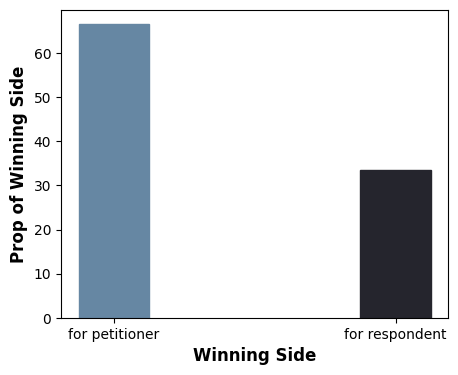

In [5]:
simple_bar_plot(xlabel, ylabel, labs, y)

### Model and plot loading

In [6]:
# Setup - Models and plots
# Load models
lr = LogisticRegression()
lr.run()

rf = RandomForest()
rf.run()

xg = XGBoost()
xg.run()

# Model Comparison DF - using advocate utterances
ADVERSARY_AGGS = "adversary_aggregations"
models = [
    "logistic regression",
    "random forest",
    "xg boost",
]
accuracy = [
    lr.accuracies[ADVERSARY_AGGS],
    rf.accuracies[ADVERSARY_AGGS],
    xg.accuracies[ADVERSARY_AGGS],
]
f1 = [
    lr.f1[ADVERSARY_AGGS],
    rf.f1[ADVERSARY_AGGS],
    xg.f1[ADVERSARY_AGGS],
]
execution_time = [
    lr.execution_times[ADVERSARY_AGGS],
    rf.execution_times[ADVERSARY_AGGS],
    xg.execution_times[ADVERSARY_AGGS],
]

model_comp = {
    "model": models,
    "accuracy": accuracy,
    "f1_score": f1,
    "execution_time": execution_time,
}
model_comp = pd.DataFrame.from_dict(model_comp)

### Finetuning Functions

In [7]:
# Value columns for long format
value_cols = [
    "case_aggregations",
    "judge_aggregations",
    "advocate_aggregations",
    "adversary_aggregations",
]


def get_long_df(
    param_name, param_values, accuracy_dicts, f1_dicts, execution_time_dicts
):
    """
    Converts the accuracy dataframes to long format for
    posterior plotting
    """
    # Dataframe of accuracy, f1 scores, and execution times
    acc_df = pd.DataFrame.from_dict(accuracy_dicts)
    f1_df = pd.DataFrame.from_dict(f1_dicts)
    et_df = pd.DataFrame.from_dict(execution_time_dicts)

    # Add parameter values to dataframe
    acc_df[param_name] = param_values
    f1_df[param_name] = param_values
    et_df[param_name] = param_values

    # Convert to long format
    acc_melted = acc_df.melt(
        id_vars=param_name, value_vars=value_cols, var_name="type"
    )
    f1_melted = f1_df.melt(
        id_vars=param_name, value_vars=value_cols, var_name="type"
    )
    et_melted = et_df.melt(
        id_vars=param_name, value_vars=value_cols, var_name="type"
    )

    return acc_melted, f1_melted, et_melted


def plot_accuracy_scores(
    melted_df, param_name, model_name, accuracy_metric=None
):
    """
    Plots accuracy scores when finetuning a parameter

    Parameters
    ----------
    param_name : str
        Name of parameter being finetuned
    melted_df : pandas dataframe
        Dataframe with accuracy scores in long format
    """

    fig_dims = (10, 12)
    fig, ax1 = plt.subplots(figsize=fig_dims)
    ax1 = sns.lineplot(
        x=param_name,
        y="value",
        data=melted_df,
        hue="type",
        style="type",
        markers=True,
        dashes=False,
        palette=["#2892D7", "#25252D", "#858D7C", "#FF9E1F"],
    )
    fig.set_size_inches(12.7, 9.27)
    plt.ticklabel_format(style="plain", axis="y")
    if accuracy_metric is None:
        ax1.set_title(
            f"Accuracy Score - {model_name} - {param_name} parameter finetuning (test set)",
            fontsize=18,
        )
        ax1.set_ylabel("Accuracy Score", fontsize=16)
    else:
        ax1.set_title(
            f"{accuracy_metric} Score - {model_name} - {param_name} parameter finetuning (test set)",
            fontsize=18,
        )
        ax1.set_ylabel(f"{accuracy_metric} Score", fontsize=16)

    ax1.set_xlabel(param_name, fontsize=16)
    plt.legend(bbox_to_anchor=(1.25, 1), loc="upper right", borderaxespad=0)

    plt.show()

## Results

### Summary Statistics

We partitioned our preliminary analysis into six sections, with our metrics being counts and averages.

**Advocates:** 
- For this analysis, we provided unique counts of advocates that were on the following sides: for the petitioner, for the respondent, unknown, or for amicus curiae. We also provided counts of the total unique advocates across all the cases, the unique roles that attributes can have, and a count of aggregate roles that advocates can have. We determined these aggregate roles by doing visual text analyses of a subset of the roles listed in the dataset. This led to the following aggregate roles that advocates could take: inferred, for the respondent, for the petitioner, and for amicus curiae.
- The majority of advocates worked on the side of the petitioner (approximately 39%), and the majority of the advocate roles were inferred by the dataset creator (about 37%).

**Cases:**
- For this analysis, we provided descriptives statistics of the count of cases on each win side (for the petitioner, for the respondent, unclear, or unavailable); a count of total cases; the count of courts cases span; the total number of years the cases dataset span; the total number of unique petitioners; and the total number of unique respondents.
- About 65% of cases ruled in favor of the petitioner. 

**Speakers:**
- This analysis describes the speakers present across the cases. Speakers took on 1 of 3 roles: advocates, justices, or unknown. The majority of speakers were advocates, with only 35 speakers being justices. The dataset also included approximately 8900 unique speakers.

**Voters:**
- For this analysis we counted the sum total of positive, negative, and absent votes from justices along with the total number of justices that voted over the span of 65 years (1955 to 2019).
- Within that timespan 35 justices were accounted for in the records, roughly 59% of votes were positive, 40% of votes were negative, and 1% of votes were not cast as either positive or negative. 

**Utterances:**
- For this analysis we counted the average number of utterances per case and the average number of speakers that showed up per case.
- The average number of utterances per case was approximately 253 and the average number of speakers per case was 10.

### Case Information
Includes infromation on each <i>court case</i>, such as:
- Unique case ID
- Year and title of case
- Case petitioner and respondent
- Winning side (1 = for petitioner) and decision date

In [8]:
ds.cases_stats

counts  percentages
win side             for petitioner   284.0    66.510539
                     for respondent   143.0    33.489461
cases                                 427.0          NaN
courts                                  1.0          NaN
years (2014 to 2019)                    6.0          NaN
petitioners                           413.0          NaN
respondents                           356.0          NaN

### Speakers
Includes infromation on each <i>speaker</i>, such as:
- Speaker name and unique speaker key
- Speaker role and type (justice, advocate, nan)

In [9]:
ds.speakers_stats

counts  percentages
speaker type  advocate (A)  8942.0    99.610115
              justice (J)     35.0     0.389885
speaker names               8928.0          NaN
speaker keys                8977.0          NaN

### Voters
Includes infromation on each <i>vote and voter</i>, such as:
- Unique case ID
- Voter key and vote side (judges only, 1=for petitioner)

In [10]:
ds.voters_stats.head(7)

counts percentages
votes    for petitioner        1912.0   60.659898
         for respondent        1240.0   39.340102
justices                         11.0         NaN
justice  j__john_g_roberts_jr     363    0.661157
         j__antonin_scalia         66    0.651515
         j__anthony_m_kennedy     240    0.658333
         j__clarence_thomas       364    0.532967

### Advocates
Includes infromation on each <i>advocate (non-judges)</i>, such as:
- Unique case ID
- Advocate ID and advocacy side(1 = for petitioner)
- Advocate role

In [11]:
ds.advocates_stats

counts  percentages
side            for petitioner   403.0    50.124378
                for respondent   401.0    49.875622
total advocates                  391.0          NaN
total roles                      154.0          NaN
aggregate roles inferred          10.0     1.243781
                for respondent   404.0    50.248756
                for petitioner   390.0    48.507463

### Conversations
Includes infromation on each <i>conversation</i>. There is one conversation per case, <br>
and conversations are made up of individual utterances. Conversation information includes:

- Unique case ID
- Unique conversation ID
- Winning side (1 = for petitioner)

In [12]:
conversations.head(2)

,id,case_id,winning_side
0,23291,2014_13-553,1
1,23252,2014_13-895,1


### Utterances
Includes infromation on each <i>utterance</i>, such as:
- Unique case ID
- Corresponding conversation ID
- Speaker key
- Utterance text

In [13]:
cols = ["case_id", "speaker", "speaker_type", "conversation_id", "text"]
utterances.head(2).loc[:, cols]

,case_id,speaker,speaker_type,conversation_id,text
0,2014_13-553,j__john_g_roberts_jr,J,23291,"we'll hear argument next in case no. 13-553, t..."
1,2014_13-553,andrew_l_brasher,A,23291,"thank you, mr. chief justice, and may it pleas..."


## Hypothesis

We can hypothesize that XGBoost performs the best. Logistic regression performs well with sparse high-dimensional data and often used for NLP tasks. Random Forests go one step further and capture non-linear relationships between features, which might be more useful in predicting case rulings. Without hyperparameter tuning, however, it is still possible to overfit. 

More than these two models, however, we hypothesize that XGBoost may perform slightly better due to its flexibility in various imbalanced data. XGBoost uses gradient boost, which can help correct the errors of the ensemble. XGBoost also has a regularization parameter that is not as often used in logistic regression and random forest. With the right tuning, it is possible to guess that XGBoost could perform better. XGBoost also handles missing data well.

XGBoost did indeed perform better until additional variables were added to the model, where Logistic Regression managed to slightly outperform XGBoost. This is likely due to the fact that XGBoost is more prone to overfitting, and the additional variables may have caused the model to overfit. However, the three models performed similarly, a result we are happy with.

## Model Analysis

## General Insights

As the code and plots below will show, the advocate and adversary utterances have a much higher predictive power than models using judge utterances or a combination of all utterances. This result held true for the three models, Logistic Regression, Random Forest, and XGBoost. Also, even though we finetuned several hyperparameters for each model, those trained with advocate and adversary utterances still performed better than those trained with judge utterances or a combination of all utterances.

Regarding the time execution, Random Forests was the less time consuming model, followed by XGBoost and Logistic Regression. This is likely due to the fact that Random Forests is a simpler model than XGBoost and Logistic Regression, which require more iterations to converge.


## Logistic Regression

**What were we able to conclude from our use of the Logistic Regression model?** 

We applied logistic regression models to four different datasets and observed the below results. We used the following hyperparameters as defaults in our regression, with a test size of `0.2`. Such hyperparameters are finetuned in the next code section.

- **Maximum number of iterations**: 1000
- **Maximum number of features**: 5000

We also used four datasets, and models based on advocate and adversary utterances achieved higher accuracies than those using judge utterances or a combination of all utterances. As the previous paragraph mentioned, the logistic regression model provided insights into the predictive power of different utterances, indicating that advocate and adversary statements are more predictive than the more than judge utterances, and all utterances aggregated together for case outcomes (this held true during our finetuning process as well).

Also, when adding additional variables (like number of words and the case's corresponding year), the Logistic Regression Model had a better accuracy overall, even outperforming its counterparts.

Finally, during the finetuning exercise, both hyperparameters did not have a significant impact on accuracy.

## Random Forest

**What were we able to conclude from our use of the Random Forest model?** 

We picked the Random Forest model because we needed to capture the complex interactions among different words in unstructured data, to avoid overfitting our model by training on multiple decision trees, and to rank the importance of different words on the predicted outcome. We can confirm the model's accuracy by predicting case outcomes from the results, which gives us a view of each unique word's importance. If we were to use this model for cross-validation, or out-of-sample data, we could also see how well the model generalizes and avoids overfitting.

The default hyperparameters were:

- **Maximum number of features**: 5000
- **Number of trees**: 100


These parameters will be finetuned in the code below. For this model, we also used a test size of `0.20`. In our short finetuning exercise, the hyperparameter which impacted most the accuracy scores was the maximum tree depth allowed. The number of trees did not have such a significant impact on the accuracy scores.

## XGBoost

**What were we able to conclude from our use of the XG Boost model?** 

A crucial insight is that ensemble models tend to perform better than 'single' models. In this case, XGBoost uses several decision trees to make the final prediction while adjusting the model on every iteration. This allows the model to learn from its mistakes and improve on every iteration, which leads to a better overall performance.

On the other hand, however, ease of interpretation is lost, and a lengthy finetuning process is necessary to get the best set of hyperparameters for our context. Opposite to Logistic Regression, we did not see a significant improvement in accuracy when adding additional variables to the model. Our hypothesis is that we needed a much more robust fine-tuning process make the most out of such additional variables 


The default hyperparameters used for this model were:

- **Maximum number of features**: 5000
- **Test size**: 0.20
- **Maximum depth**: 7
- **Number of estimators**: 100
- **Learning rate**: 0.3
- **Subsamples**: 1

<!-- Can print out IDs of which ones are misclassified. Point out /trace back to the data.  -->

In [14]:
ds.cases_stats.loc[:, ["percentages"]].head(2)
xlabel = "Winning Side"
ylabel = "Prop of Winning Side"
labs = ["for petitioner", "for respondent"]
y = list(ds.cases_stats.iloc[:2, 1])

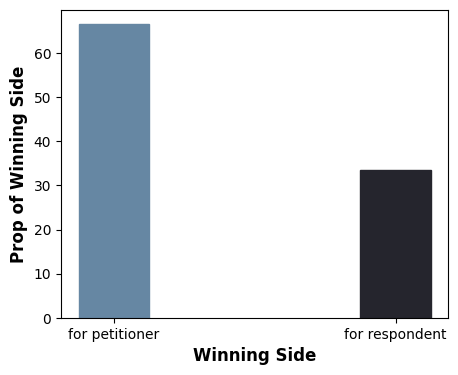

In [15]:
simple_bar_plot(xlabel, ylabel, labs, y)

In [16]:
lr_acc = dict_to_df(
    ["dataset", "accuracy", "f1_score", "execution_time"],
    lr.accuracies,
    lr.f1,
    lr.execution_times,
)
lr_acc

,dataset,accuracy,f1_score,execution_time
0,case_aggregations,0.527027,0.646465,0.646465
1,judge_aggregations,0.520548,0.631579,0.631579
2,advocate_aggregations,0.810811,0.851064,0.851064
3,adversary_aggregations,0.837838,0.877551,0.877551


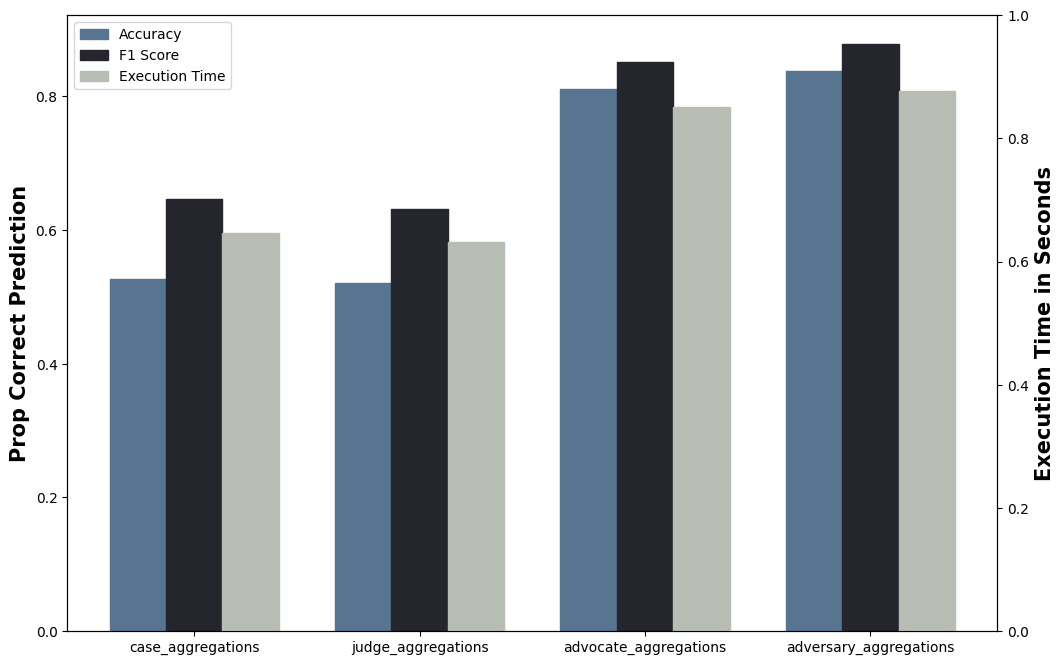

In [17]:
disp_accuracy(lr_acc, labs=list(lr_acc["dataset"]))

### Confusion Matrices
#### Logistic Regression Model - All Utterances

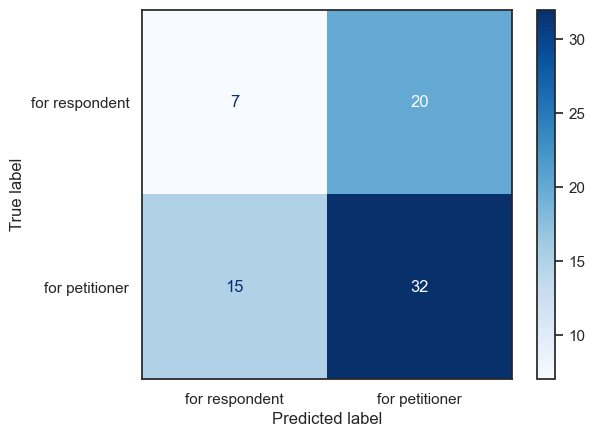

In [18]:
disp_conf_matrix(lr.confusion_matrix["case_aggregations"])

#### Logistic Regression Model - Judge Utterances

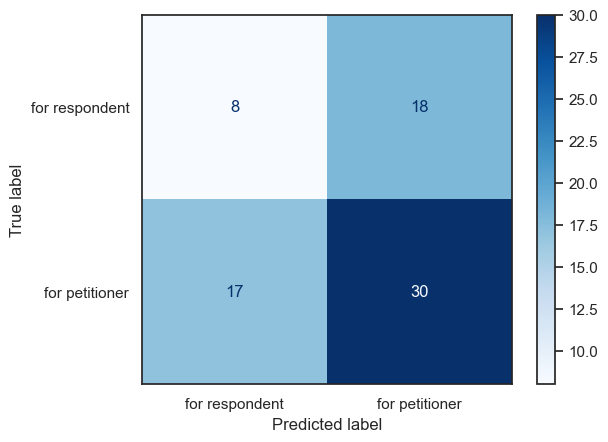

In [19]:
disp_conf_matrix(lr.confusion_matrix["judge_aggregations"])

#### Logistic Regression Model - Advocate Utterances

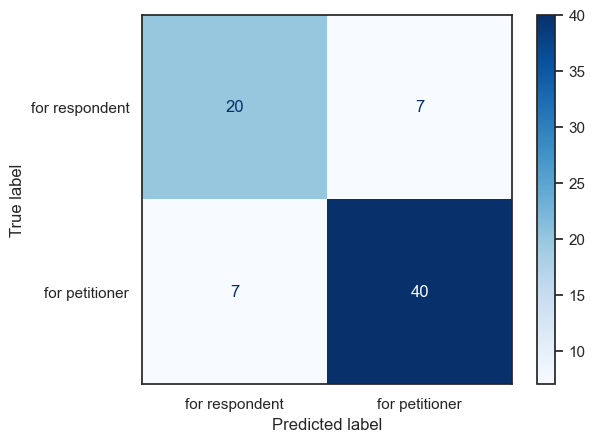

In [20]:
disp_conf_matrix(lr.confusion_matrix["advocate_aggregations"])

#### Logistic Regression Model - Adversary Utterances

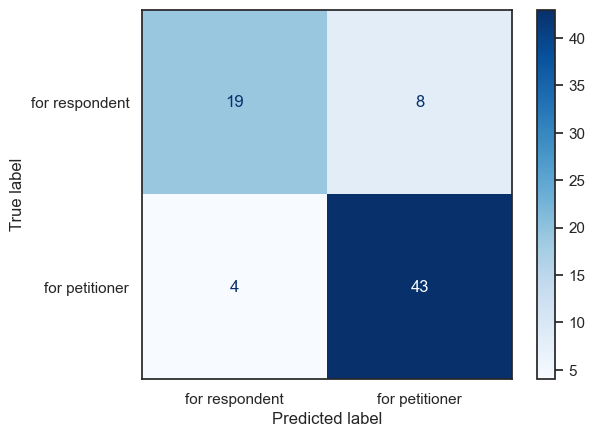

In [21]:
disp_conf_matrix(lr.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning - Maximum Iterations

In [22]:
# Array of values for tuning
max_feature_values = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
max_iter_values = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

# Model parameters
maxfeat = "Max Features"
maxiter = "Max Iterations"
lr_label = "Logistic Regression"

#### Maximum Number of Iterations Finetuning

In [23]:
# Do max features finetuning
accuracy_dicts = []
f1_dicts = []
exec_times_dicts = []

for max_iter_value in max_iter_values:
    lr_model = LogisticRegression(debug_mode=False, max_iter=max_iter_value)
    lr_model.run()

    accuracy_dicts.append(lr_model.accuracies)
    f1_dicts.append(lr_model.f1)
    exec_times_dicts.append(lr_model.execution_times)


print("Done parameter finetuning for max iterations")

max_iter_melted, max_iter_f1_melted, et_df = get_long_df(
    "Max Iterations",
    max_iter_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=exec_times_dicts,
)

c:\Users\fdmol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\fdmol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Done parameter finetuning for max iterations


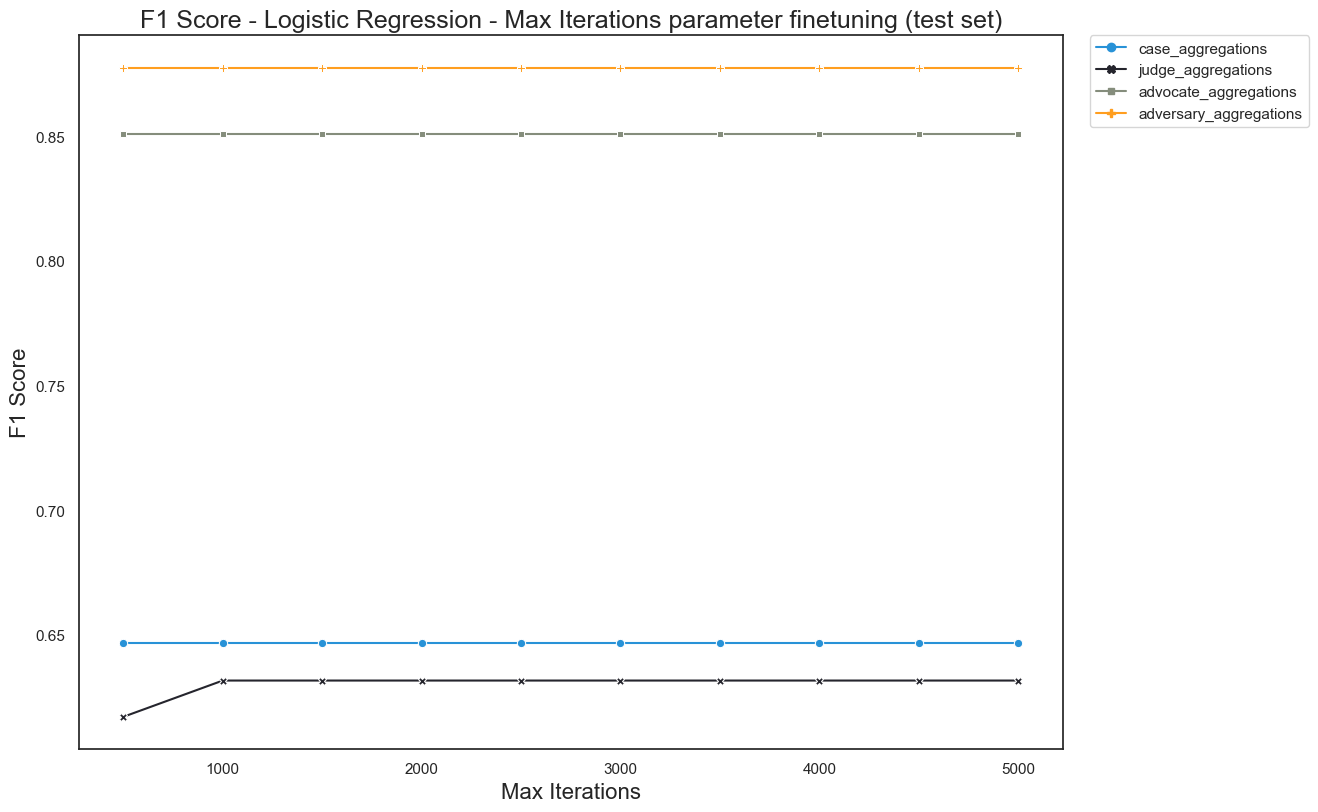

In [24]:
plot_accuracy_scores(
    max_iter_f1_melted, maxiter, lr_label, accuracy_metric="F1"
)

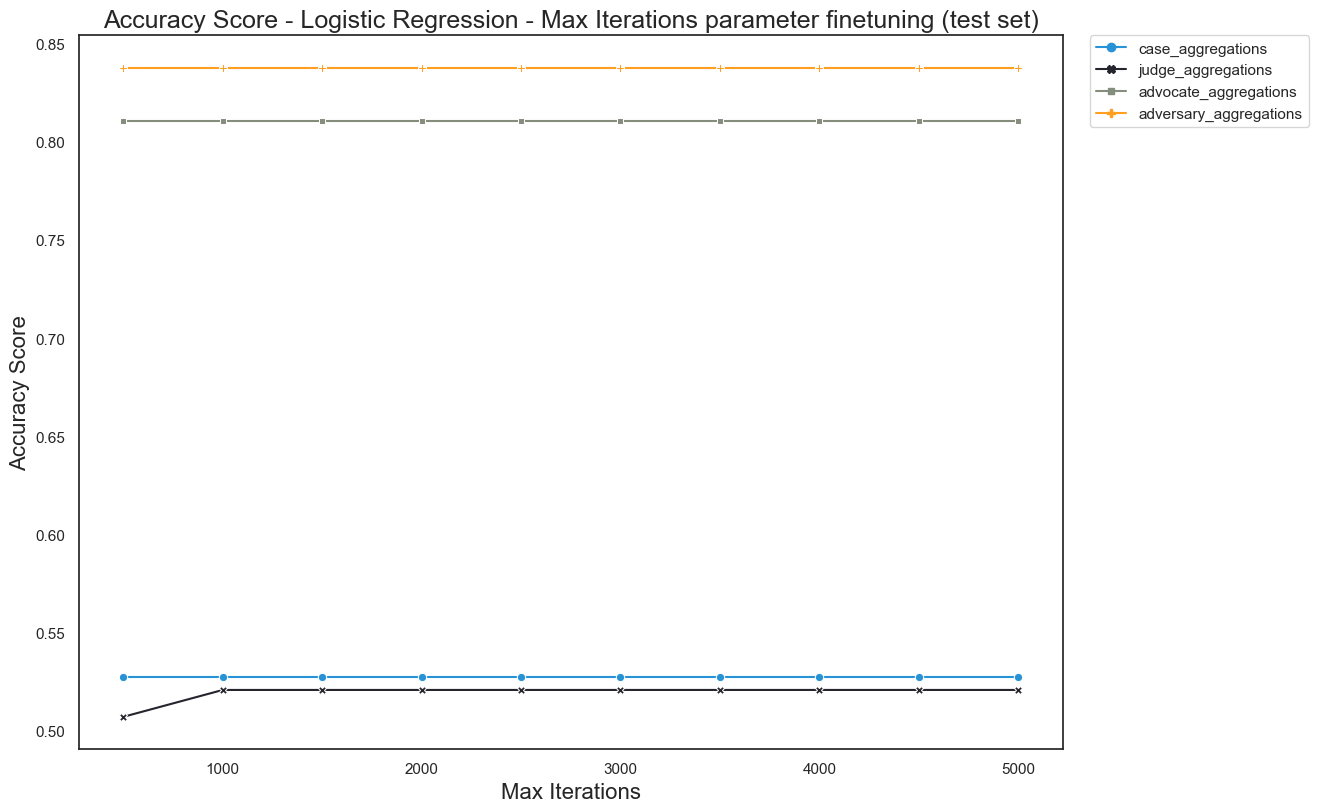

In [25]:
plot_accuracy_scores(max_iter_melted, maxiter, lr_label)

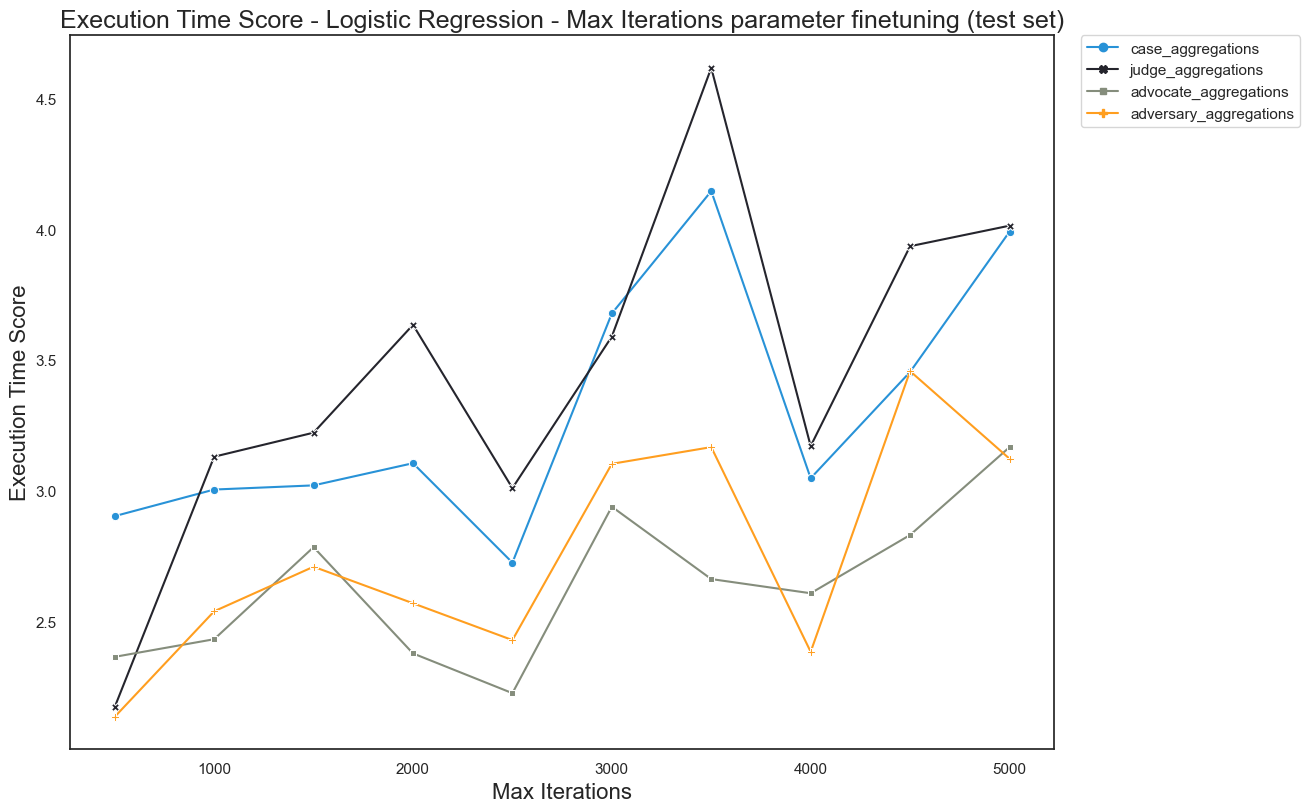

In [26]:
plot_accuracy_scores(et_df, maxiter, lr_label, accuracy_metric="Execution Time")

#### Max Features Finetuning

In [27]:
# Do max features finetuning
accuracy_dicts = []
f1_dicts = []
exec_times_dicts = []

for max_feature_value in max_feature_values:
    lr_model = LogisticRegression(
        debug_mode=False, max_features=max_feature_value
    )
    lr_model.run()

    accuracy_dicts.append(lr_model.accuracies)
    f1_dicts.append(lr_model.f1)
    exec_times_dicts.append(lr_model.execution_times)


print("Done parameter finetuning for max features")

max_feature_lr_melted, max_feature_f1_lr_melted, et_df = get_long_df(
    "Max Features",
    max_feature_values,
    accuracy_dicts,
    f1_dicts,
    exec_times_dicts,
)

c:\Users\fdmol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\fdmol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Done parameter finetuning for max features


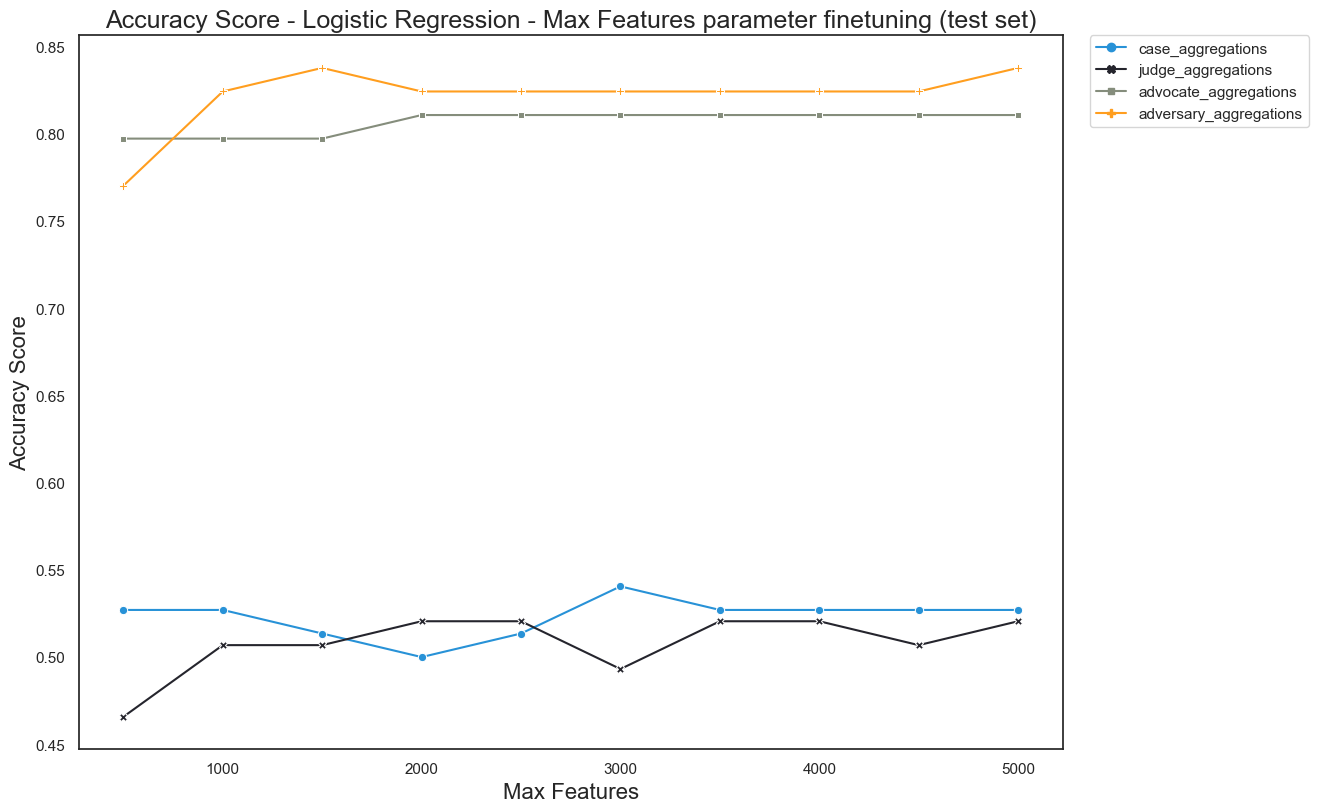

In [28]:
plot_accuracy_scores(max_feature_lr_melted, maxfeat, lr_label)

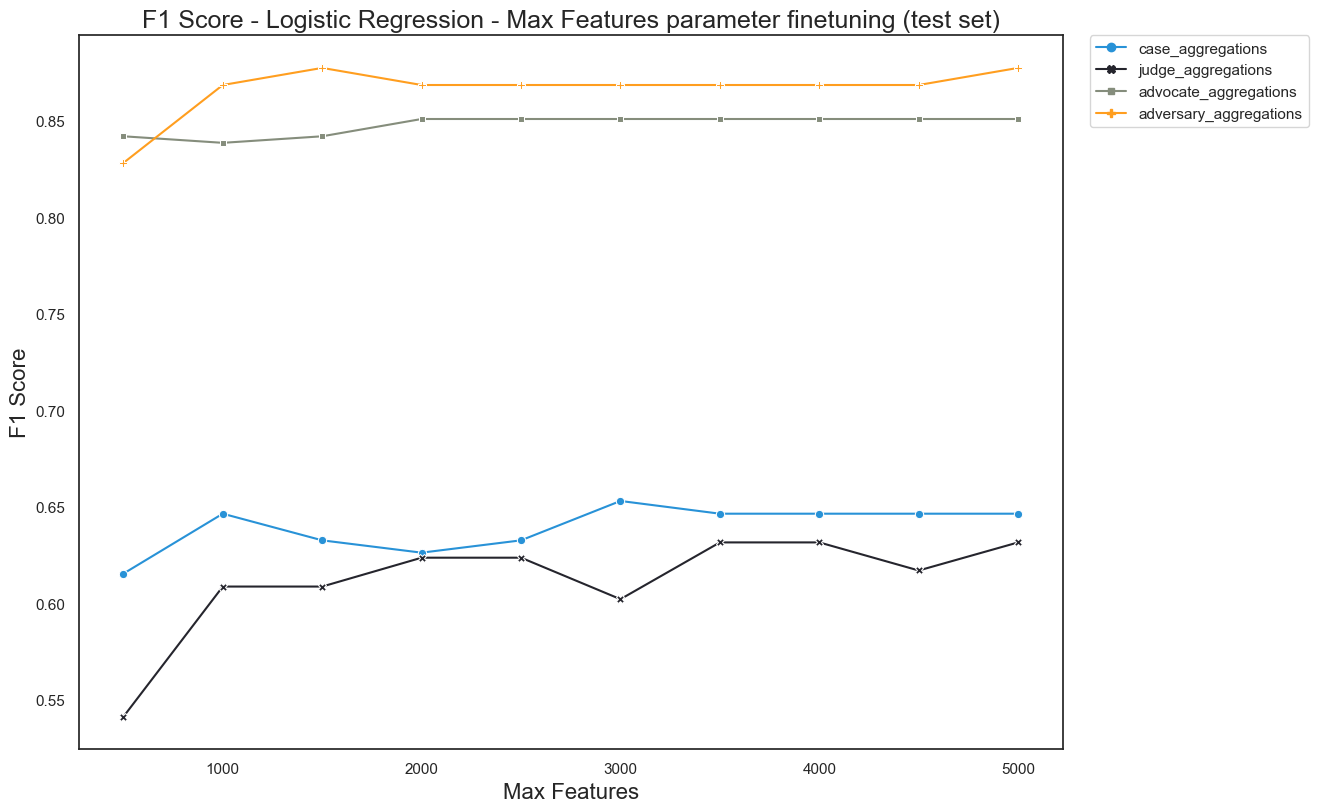

In [29]:
plot_accuracy_scores(
    max_feature_f1_lr_melted, maxfeat, lr_label, accuracy_metric="F1"
)

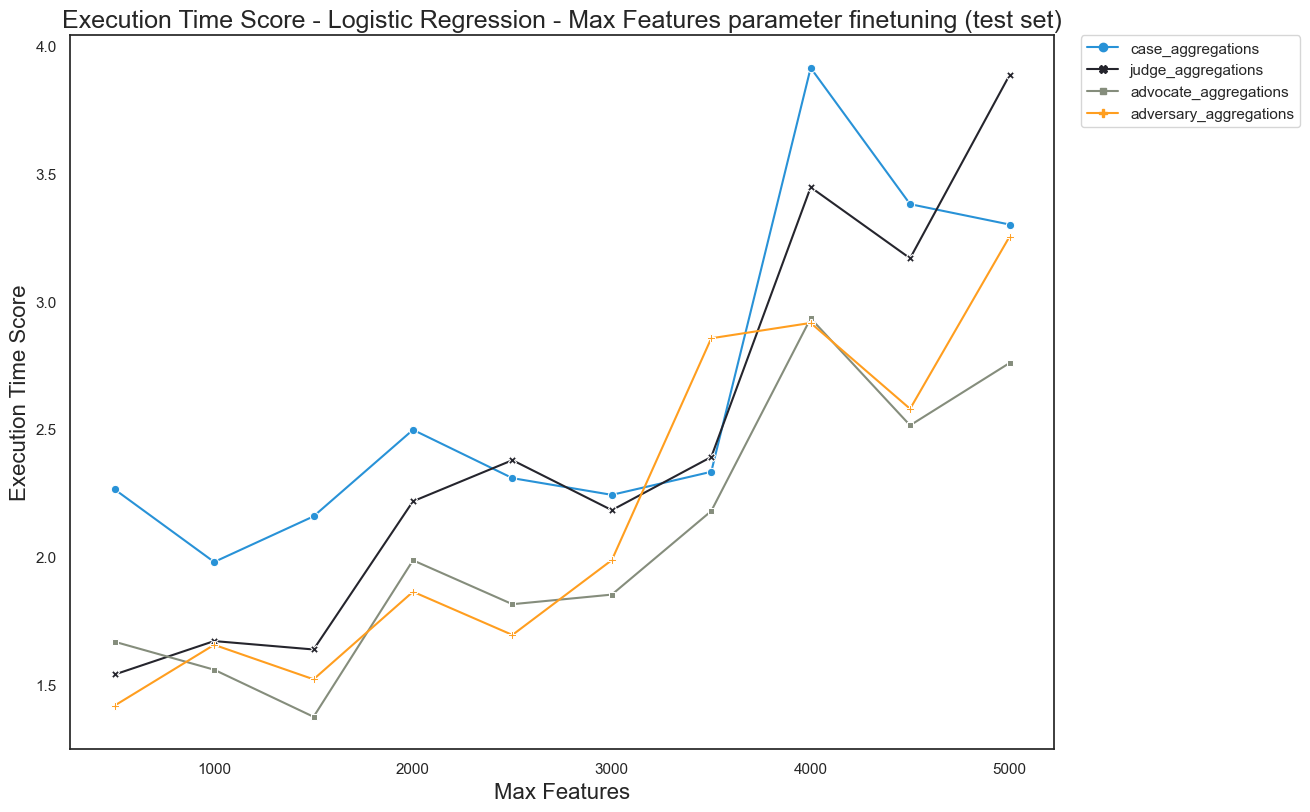

In [30]:
plot_accuracy_scores(et_df, maxfeat, lr_label, accuracy_metric="Execution Time")

## Random Forest
### Default Parameters
- **Maximum depth**: None
- **Maximum number of features**: 5000
- **Number of trees**: 100
- **Test size**: 0.20

### Accuracies and F1 Score

In [31]:
rf_acc = dict_to_df(
    ["dataset", "accuracy", "f1_score", "execution_time"],
    rf.accuracies,
    rf.f1,
    rf.execution_times,
)
rf_acc

,dataset,accuracy,f1_score,execution_time
0,case_aggregations,0.581081,0.735043,0.735043
1,judge_aggregations,0.643836,0.783333,0.783333
2,advocate_aggregations,0.810811,0.865385,0.865385
3,adversary_aggregations,0.824324,0.871287,0.871287


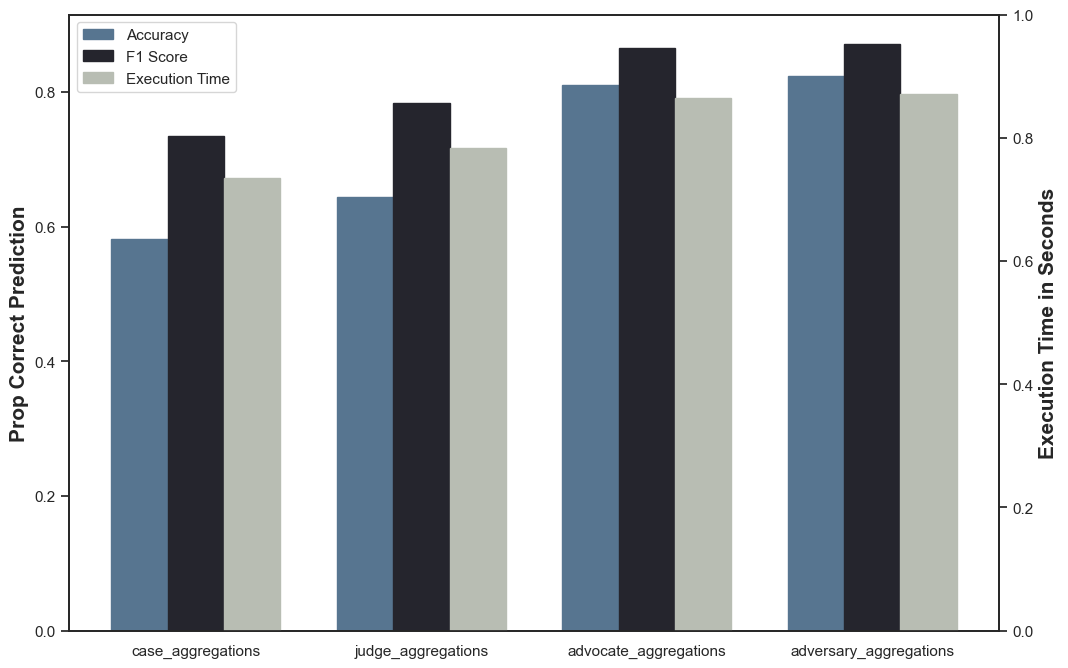

In [32]:
disp_accuracy(rf_acc, labs=list(rf_acc["dataset"]))

### Confusion Matrices
#### Random Forest Model - All Utterances

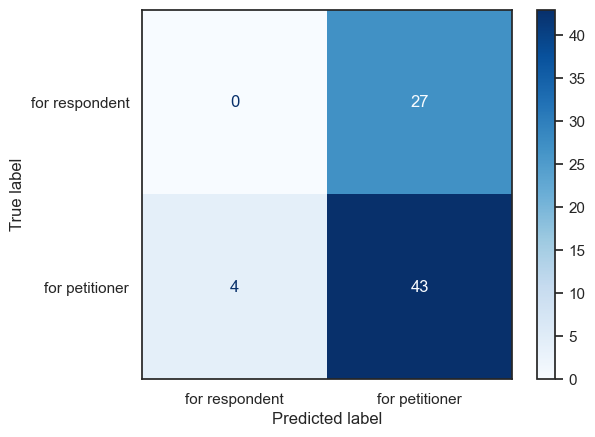

In [33]:
disp_conf_matrix(rf.confusion_matrix["case_aggregations"])

#### Random Forest Model - Judge Utterances

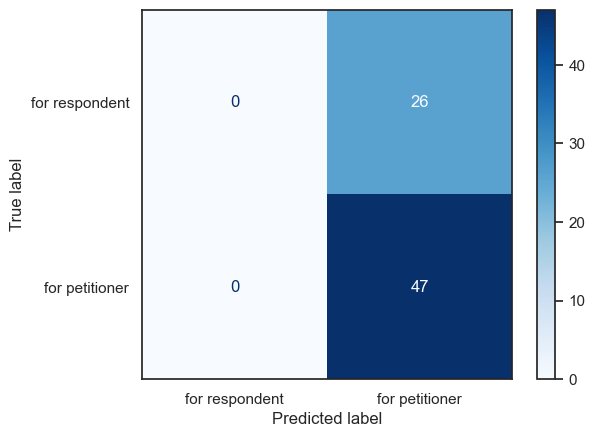

In [34]:
disp_conf_matrix(rf.confusion_matrix["judge_aggregations"])

#### Random Forest Model - Advocate Utterances

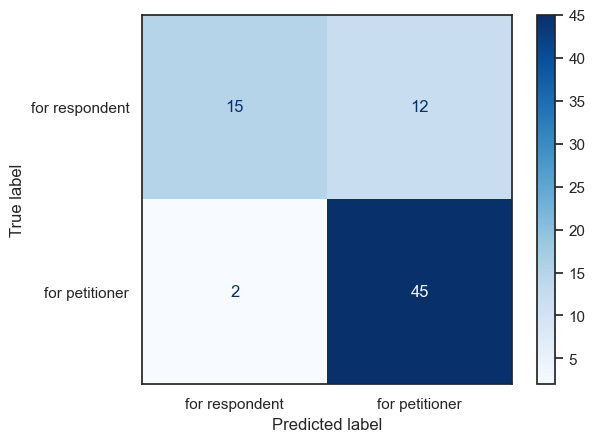

In [35]:
disp_conf_matrix(rf.confusion_matrix["advocate_aggregations"])

#### Random Forest Model - Adversary Utterances

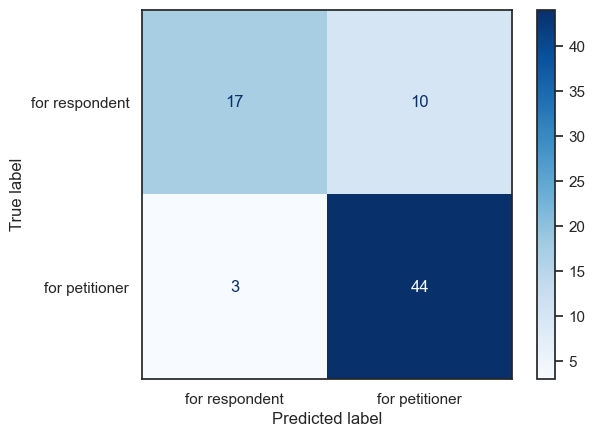

In [36]:
disp_conf_matrix(rf.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning - Maximum Tree Depth

In [37]:
# Create an array of different values to test
max_feature_values = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
num_trees_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

rf_label = "Random Forest"
ntree_lab = "Number of Trees"
maxdepth = "Max Tree Depth"

#### Max Depth Finetuning

In [38]:
accuracy_dicts = []
f1_dicts = []
exec_time_dicts = []

for max_depth_value in max_depth_values:
    rf_model = RandomForest(debug_mode=False, max_depth=max_depth_value)
    rf_model.run()

    accuracy_dicts.append(rf_model.accuracies)
    f1_dicts.append(rf_model.f1)
    exec_time_dicts.append(rf_model.execution_times)

print("Done parameter finetuning for max_depth")

max_depth_rf_melted, max_depth_f1_rf_melted, et_df = get_long_df(
    "Max Tree Depth",
    max_depth_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=exec_time_dicts,
)

Done parameter finetuning for max_depth


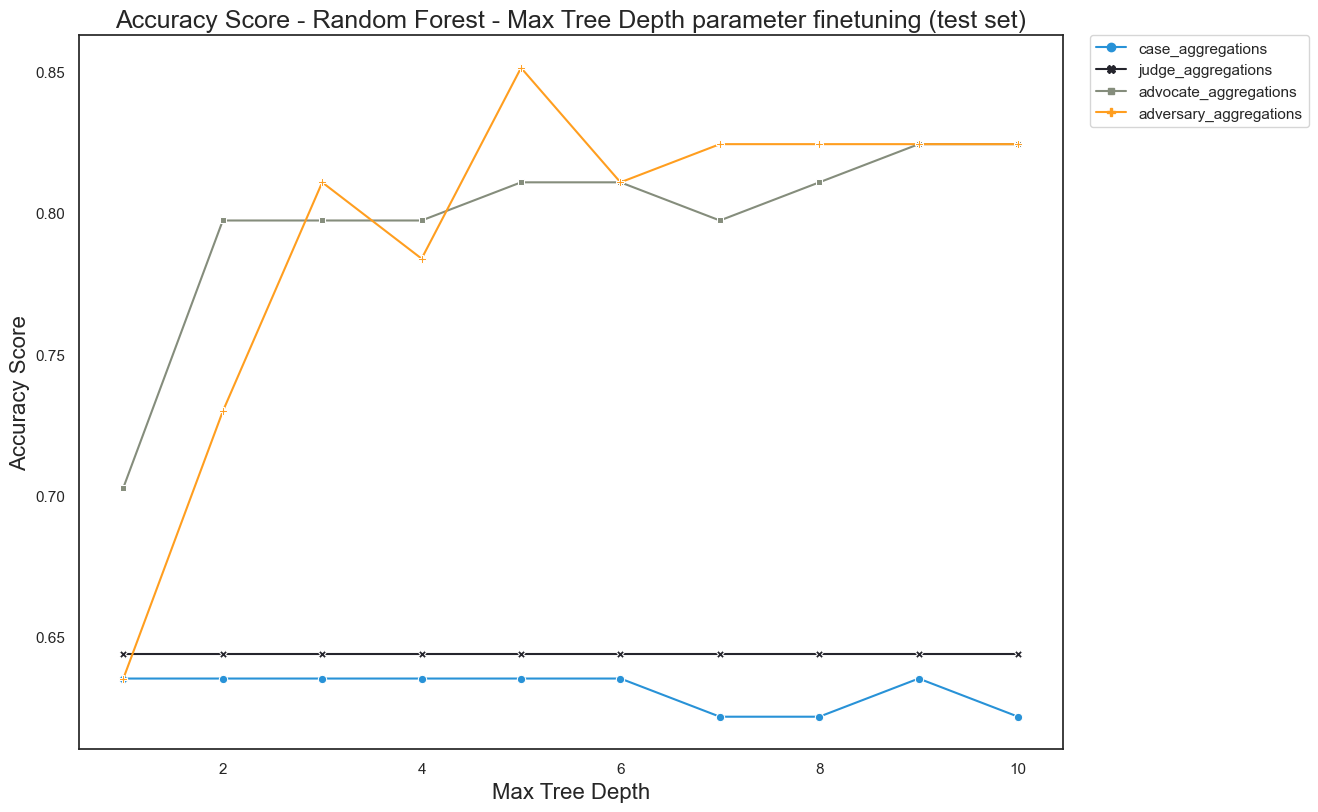

In [39]:
plot_accuracy_scores(max_depth_rf_melted, maxdepth, rf_label)

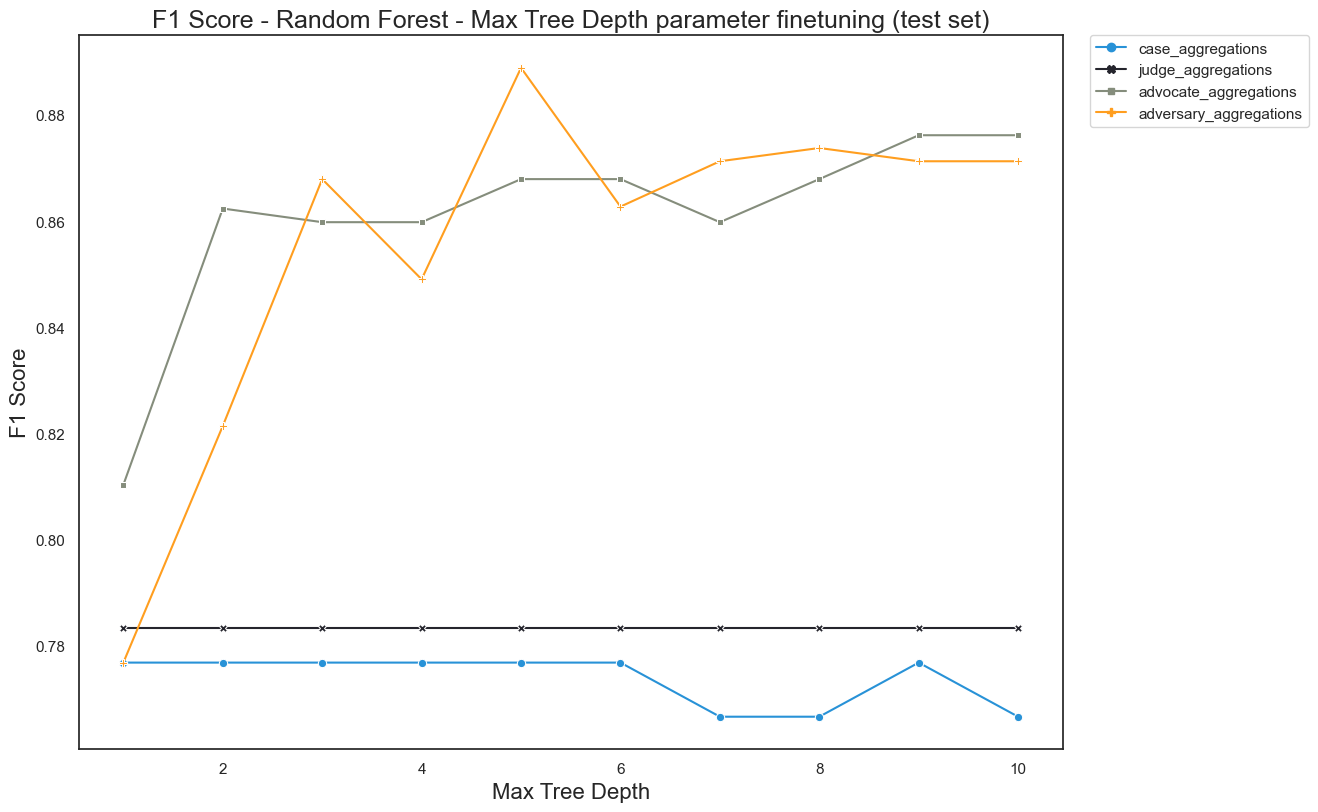

In [40]:
plot_accuracy_scores(
    max_depth_f1_rf_melted,
    maxdepth,
    rf_label,
    accuracy_metric="F1",
)

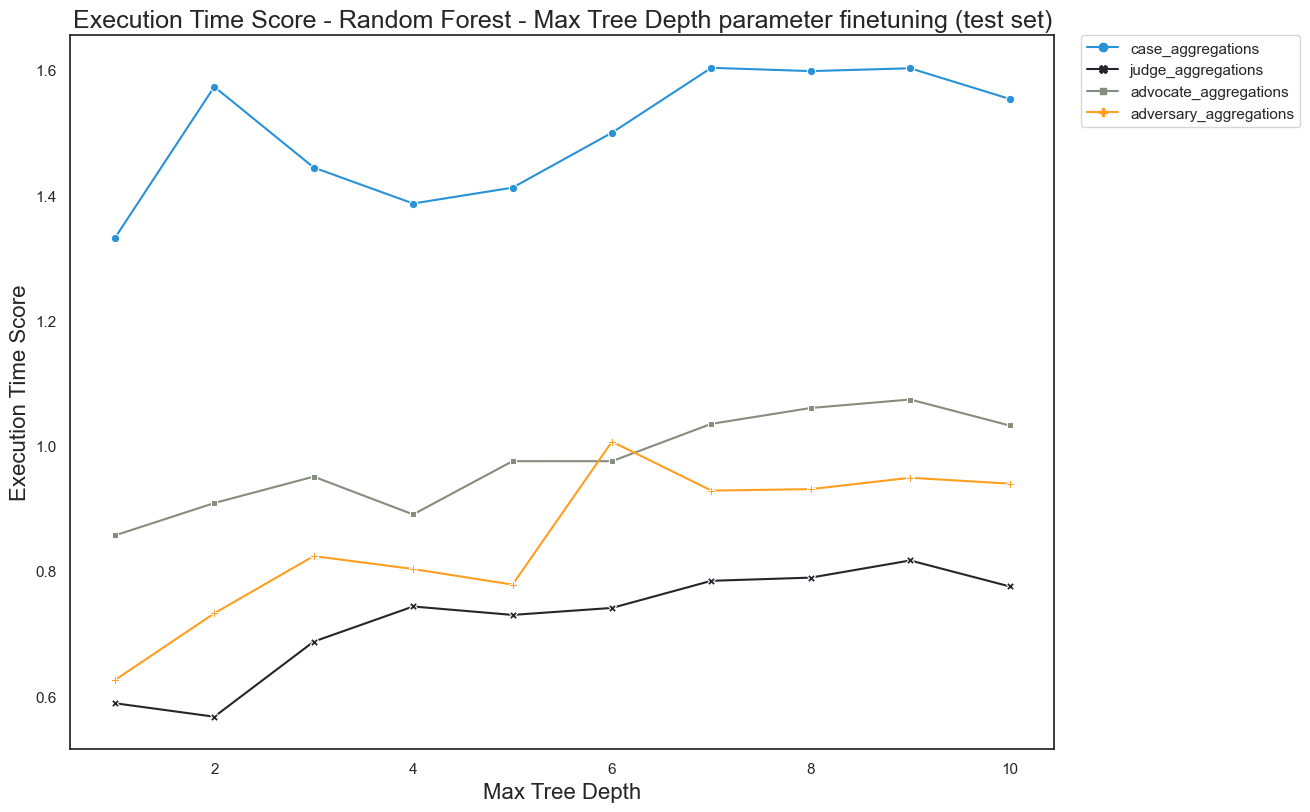

In [41]:
plot_accuracy_scores(
    et_df,
    maxdepth,
    rf_label,
    accuracy_metric="Execution Time",
)

#### Max Features Finetuning

In [42]:
# Do max features finetuning
accuracy_dicts = []
f1_dicts = []
exec_time_dicts = []

for max_feature_value in max_feature_values:
    rf_model = RandomForest(debug_mode=False, max_features=max_feature_value)
    rf_model.run()

    accuracy_dicts.append(rf_model.accuracies)
    f1_dicts.append(rf_model.f1)
    exec_time_dicts.append(rf_model.execution_times)

print("Done parameter finetuning for max features")

max_feature_melted, max_feature_f1_melted, et_df = get_long_df(
    "Max Features",
    max_feature_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=exec_time_dicts,
)

Done parameter finetuning for max features


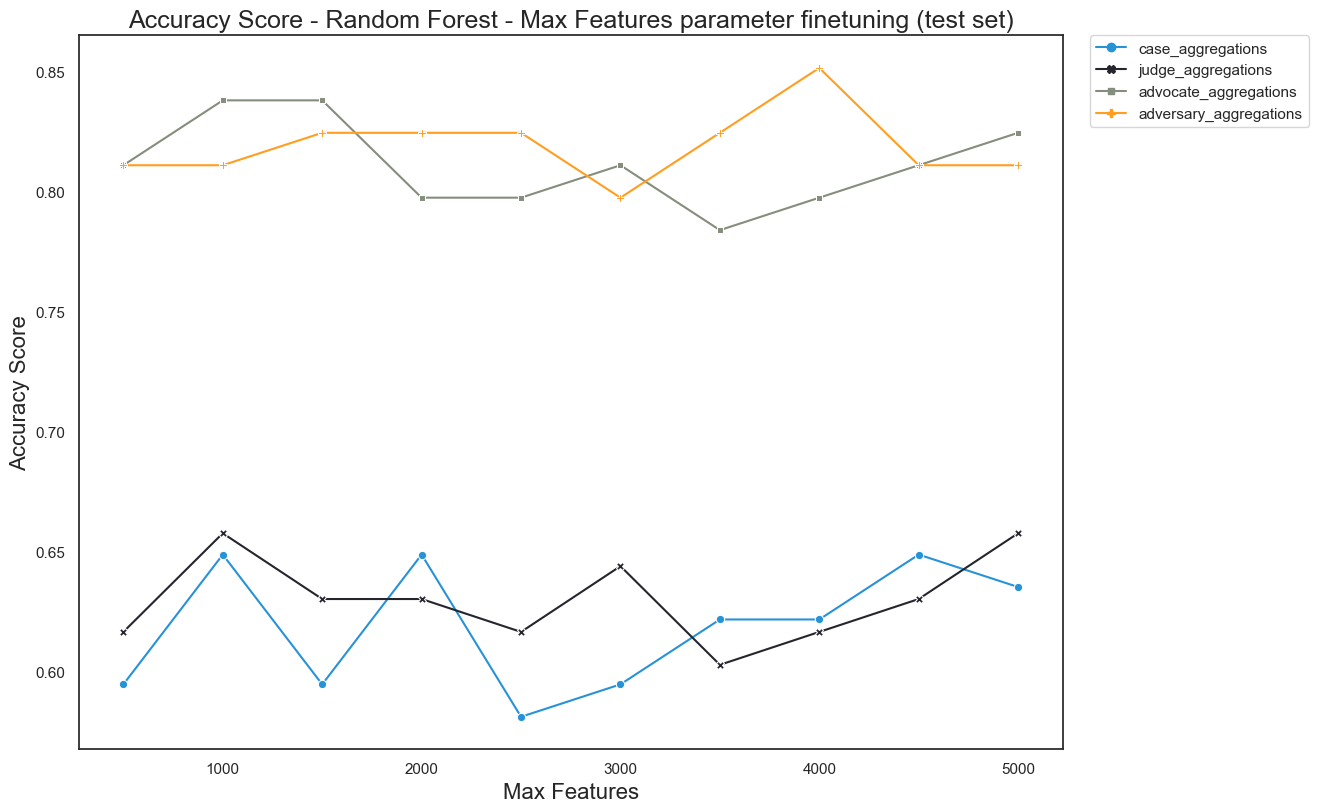

In [43]:
plot_accuracy_scores(max_feature_melted, maxfeat, rf_label)

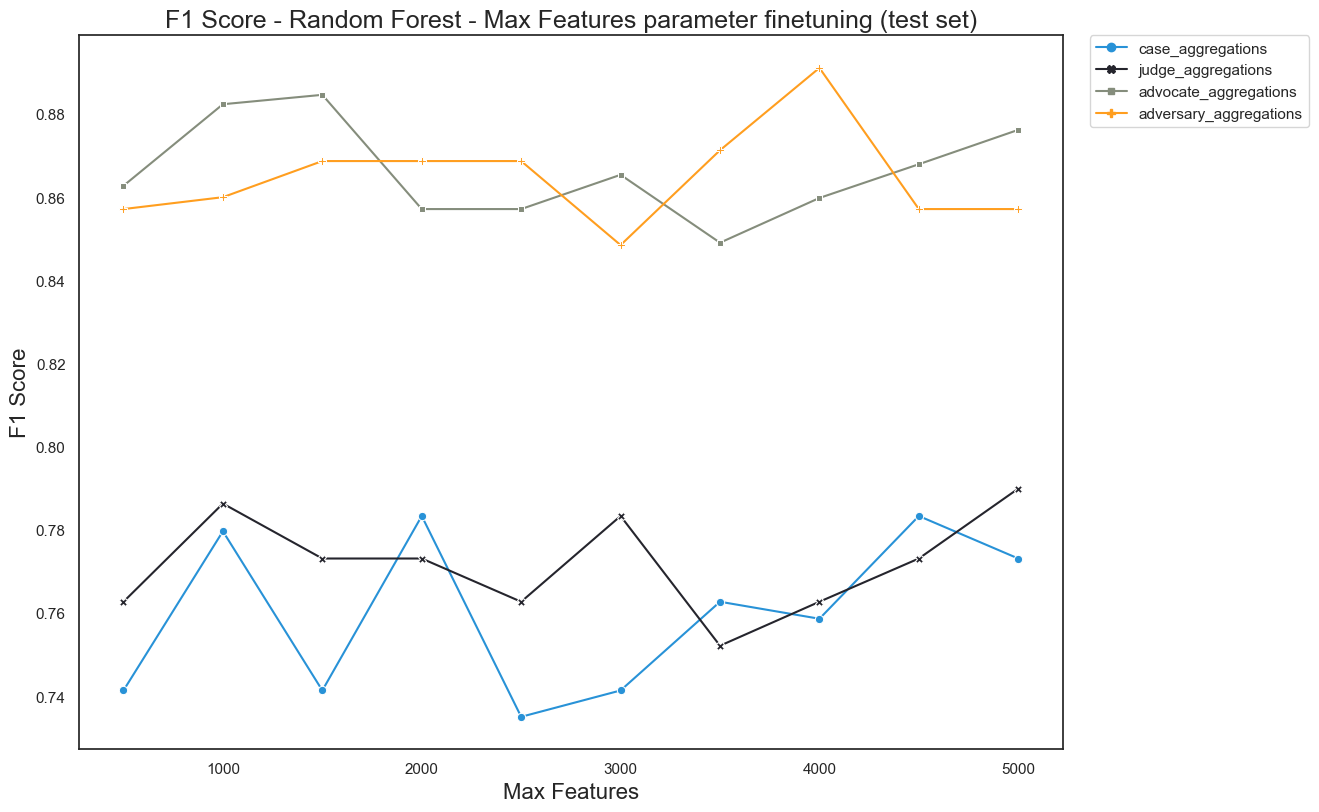

In [44]:
plot_accuracy_scores(
    max_feature_f1_melted, maxfeat, rf_label, accuracy_metric="F1"
)

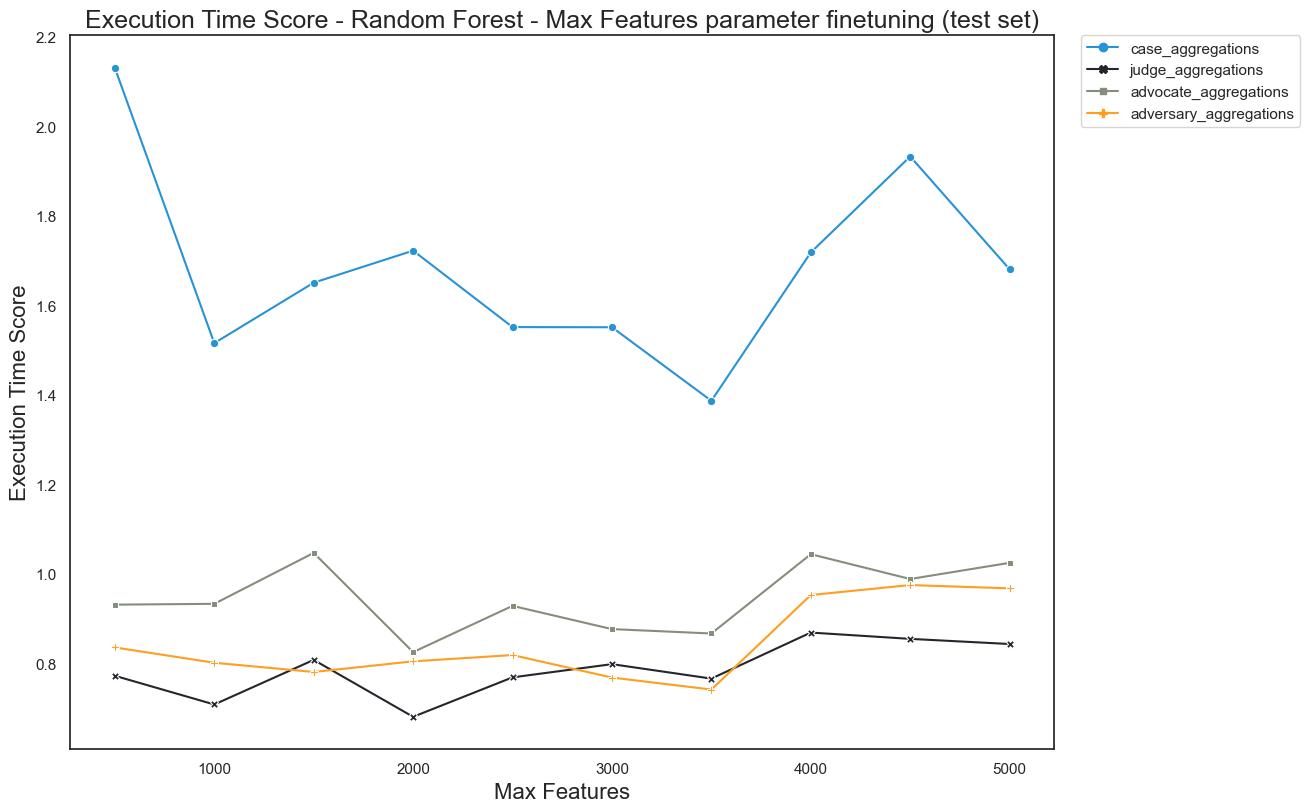

In [45]:
plot_accuracy_scores(et_df, maxfeat, rf_label, accuracy_metric="Execution Time")

#### Number of Trees Finetuning

In [46]:
# Do number of trees finetuning
accuracy_dicts = []
f1_dicts = []
exec_time_dicts = []

for num_tree_value in num_trees_values:
    rf_model = RandomForest(debug_mode=False, num_trees=num_tree_value)
    rf_model.run()

    accuracy_dicts.append(rf_model.accuracies)
    f1_dicts.append(rf_model.f1)
    exec_time_dicts.append(rf_model.execution_times)

print("Done parameter finetuning for number of trees")

num_trees_melted, num_trees_f1_melted, et_df = get_long_df(
    "Number of Trees",
    num_trees_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=exec_time_dicts,
)

Done parameter finetuning for number of trees


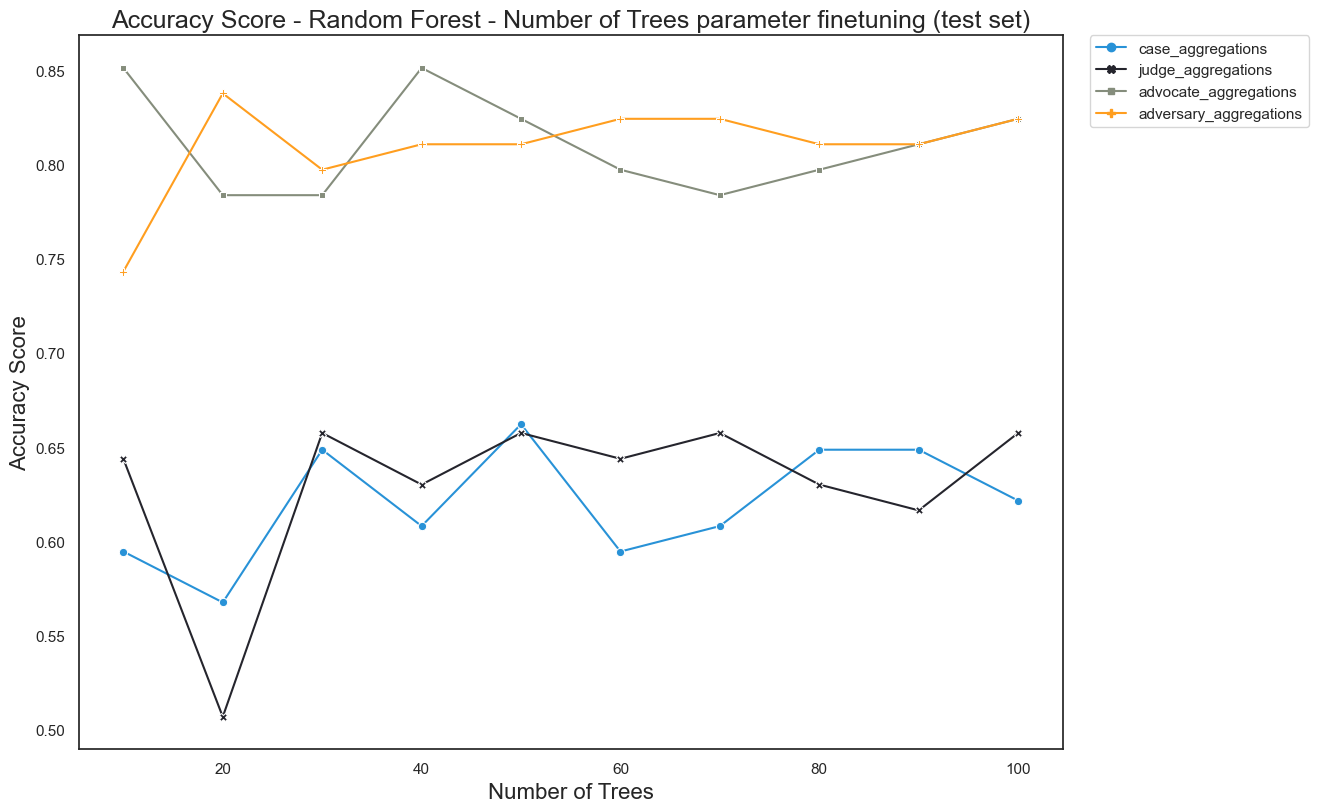

In [47]:
plot_accuracy_scores(num_trees_melted, ntree_lab, rf_label)

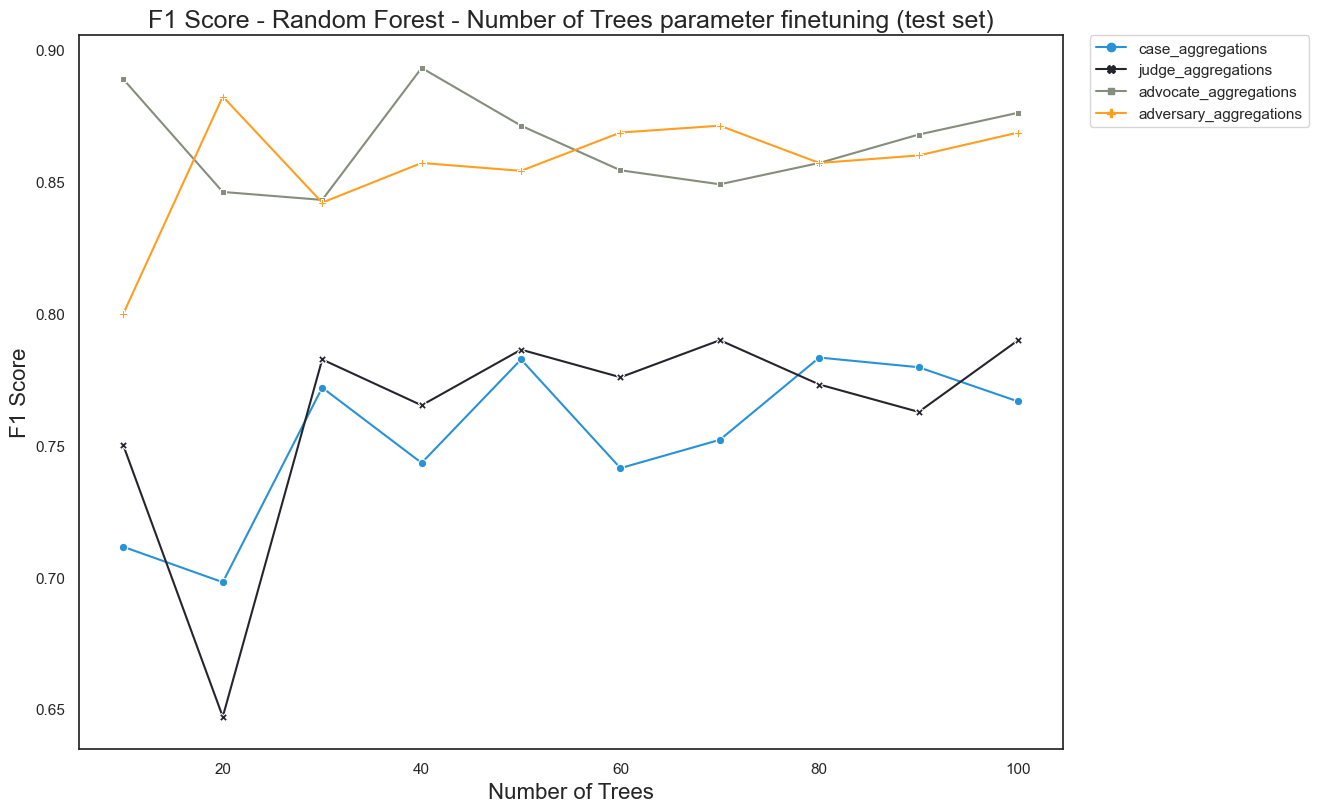

In [48]:
plot_accuracy_scores(
    num_trees_f1_melted,
    ntree_lab,
    rf_label,
    accuracy_metric="F1",
)

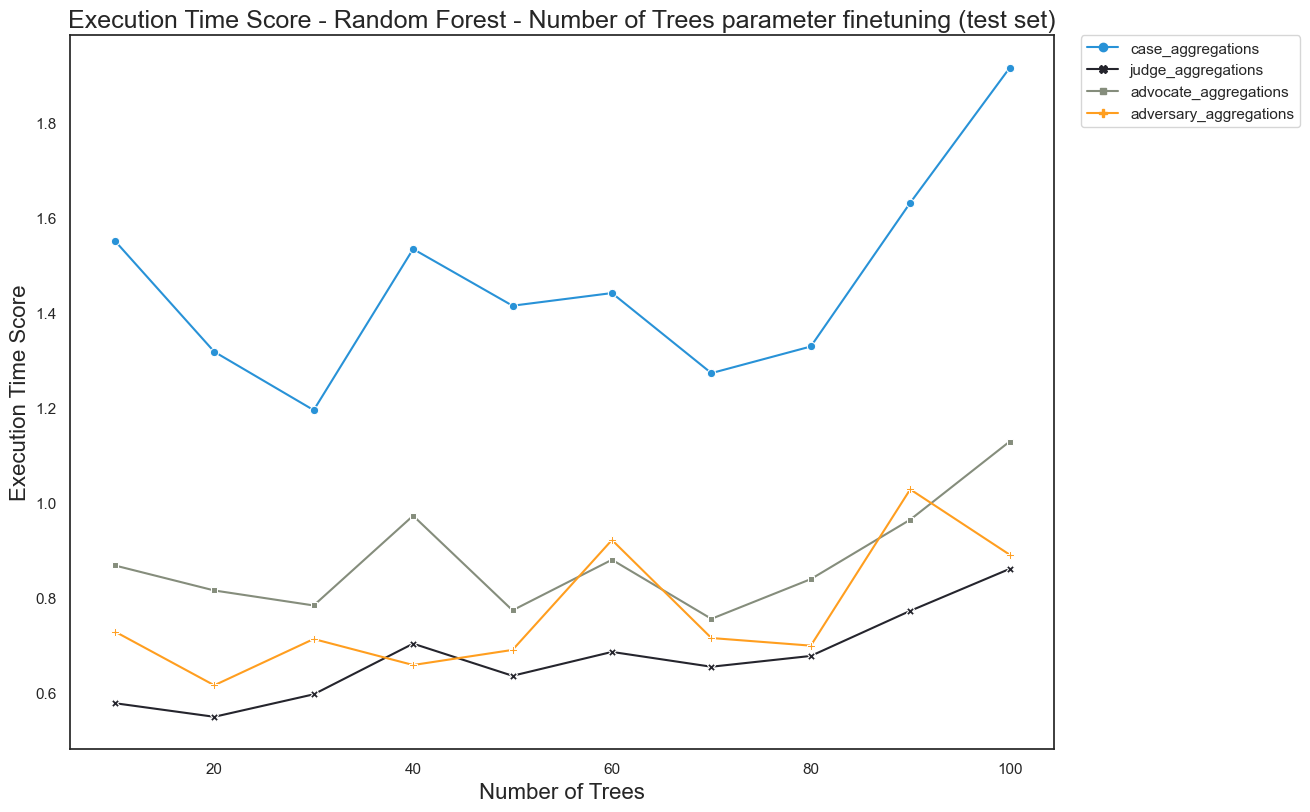

In [49]:
plot_accuracy_scores(
    et_df,
    ntree_lab,
    rf_label,
    accuracy_metric="Execution Time",
)

## Gradient Boosted Tree
### Default Parameters
- **Maximum number of features**: 5000
- **Test size**: 0.20
- **Maximum depth**: 7
- **Number of estimators**: 100
- **Learning rate**: 0.3
- **Subsamples**: 1

In [50]:
# Run baseline model
xgboost_model = XGBoost()
xgboost_model.run()
print(xgboost_model)

MODEL TYPE: Gradient Boosted Tree Model
PARAMETERS: 
	Maximum Features: 5000
	Test Size: 0.2
	Maximum Depth: 7
	Number of Trees: 100
	Learning Rate: 0.3
	Subsample: 1
ACCURACIES: 
	case_aggregations: 0.5675675675675675
	judge_aggregations: 0.547945205479452
	advocate_aggregations: 0.8108108108108109
	adversary_aggregations: 0.7972972972972973
F1 SCORES: 
	case_aggregations: 0.6862745098039216
	judge_aggregations: 0.6796116504854368
	advocate_aggregations: 0.8627450980392157
	adversary_aggregations: 0.8421052631578947EXECUTION TIME: 
	case_aggregations: 4.3558 seconds
	judge_aggregations: 3.4196 seconds
	advocate_aggregations: 3.3266 seconds
	adversary_aggregations: 2.9933 seconds


### Accuracies and F1 Score

In [51]:
xg_acc = dict_to_df(
    ["dataset", "accuracy", "f1_score", "execution_time"],
    xg.accuracies,
    xg.f1,
    xg.execution_times,
)
xg_acc

,dataset,accuracy,f1_score,execution_time
0,case_aggregations,0.567568,0.686275,0.686275
1,judge_aggregations,0.547945,0.679612,0.679612
2,advocate_aggregations,0.810811,0.862745,0.862745
3,adversary_aggregations,0.797297,0.842105,0.842105


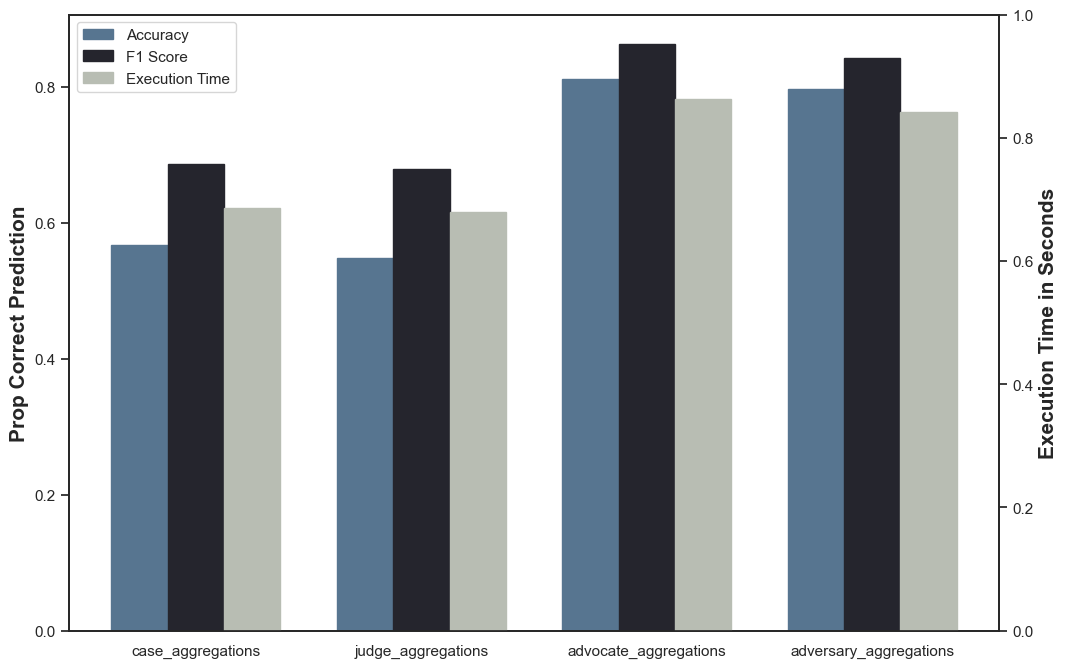

In [52]:
disp_accuracy(xg_acc, labs=xg_acc["dataset"])

### Confusion Matrices
#### Gradient Boosted Tree Model - All Utterances

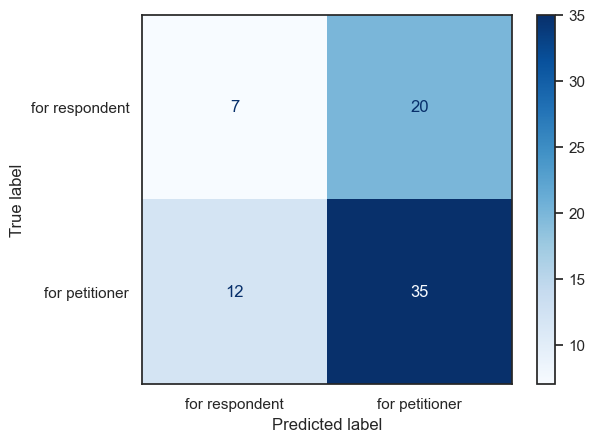

In [53]:
disp_conf_matrix(xg.confusion_matrix["case_aggregations"])

#### Gradient Boosted Tree Model - Judge Utterances

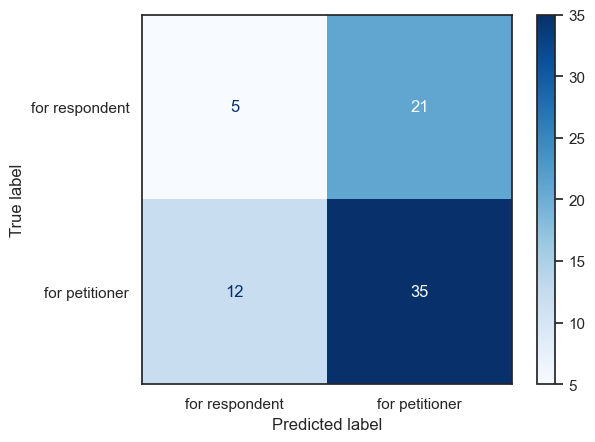

In [54]:
disp_conf_matrix(xg.confusion_matrix["judge_aggregations"])

#### Gradient Boosted Tree Model - Advocate Utterances

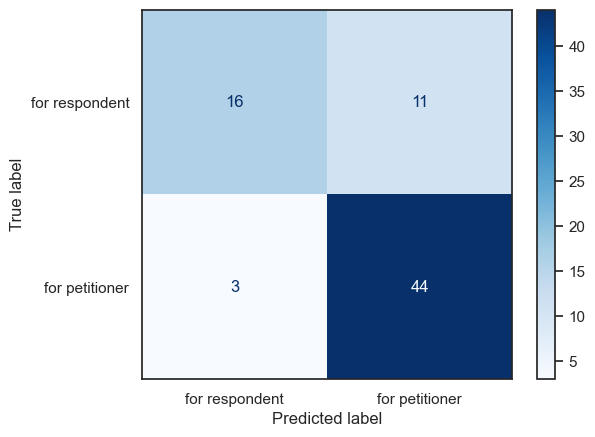

In [55]:
disp_conf_matrix(xg.confusion_matrix["advocate_aggregations"])

#### Gradient Boosted Tree Model - Adversary Utterances

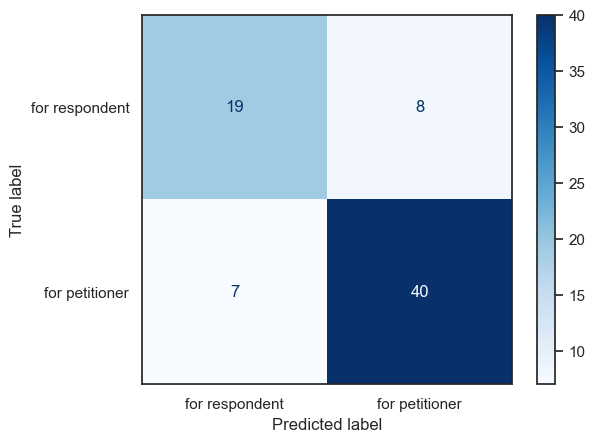

In [56]:
disp_conf_matrix(xg.confusion_matrix["adversary_aggregations"])

### Hyperparameter Tuning - Learning Rate

In [57]:
# Create an array of different values to test
eta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
subsample_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Model parameters
xg_label = "XGBoost"
eta = "eta"
subsamp = "Subsample Value"

#### Eta (Learning Rate) Finetuning

In [58]:
accuracy_dicts = []
f1_dicts = []
exec_time_dicts = []

for eta_value in eta_values:
    xgboost_model = XGBoost(debug_mode=False, eta=eta_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)
    exec_time_dicts.append(xgboost_model.execution_times)

print("Done parameter finetuning for eta")

eta_melted, eta_f1_melted, et_df = get_long_df(
    "eta",
    eta_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=exec_time_dicts,
)

Done parameter finetuning for eta


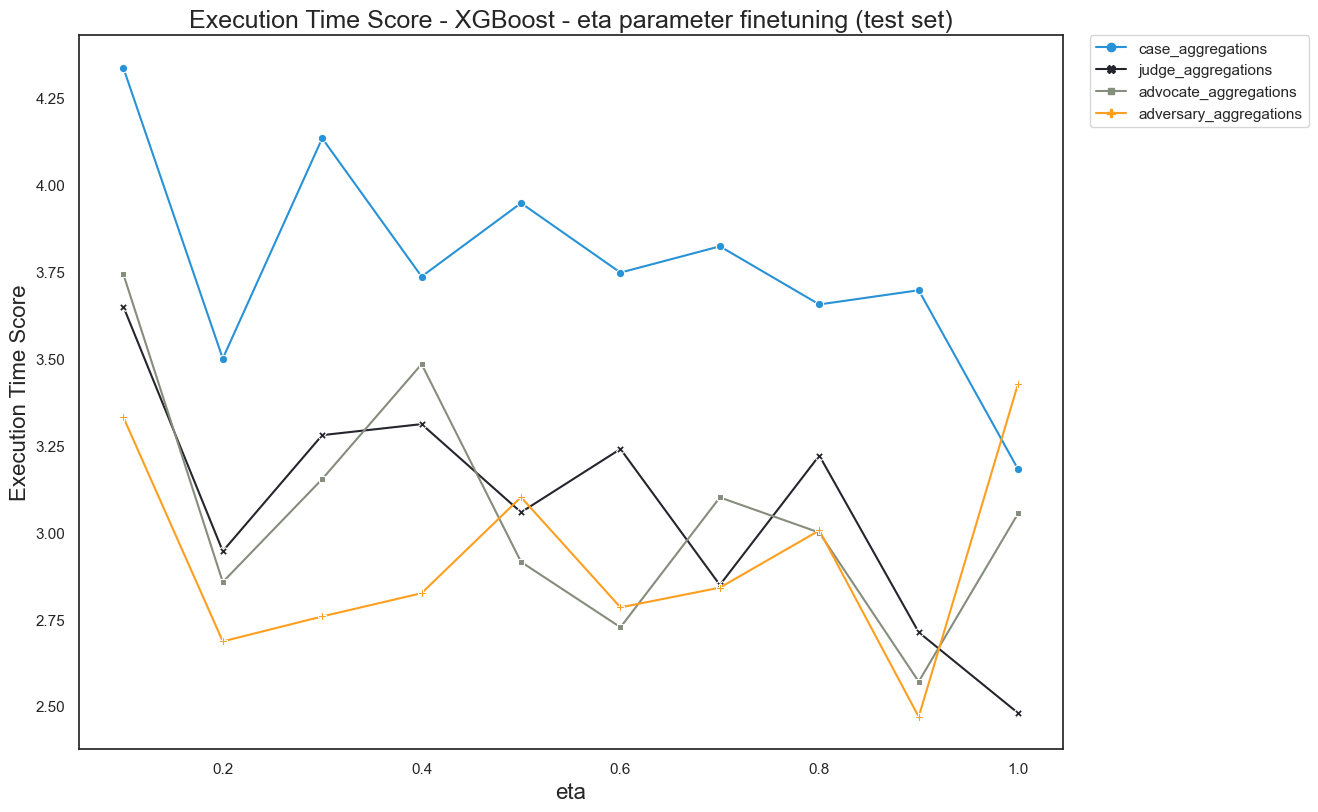

In [59]:
plot_accuracy_scores(et_df, eta, xg_label, accuracy_metric="Execution Time")

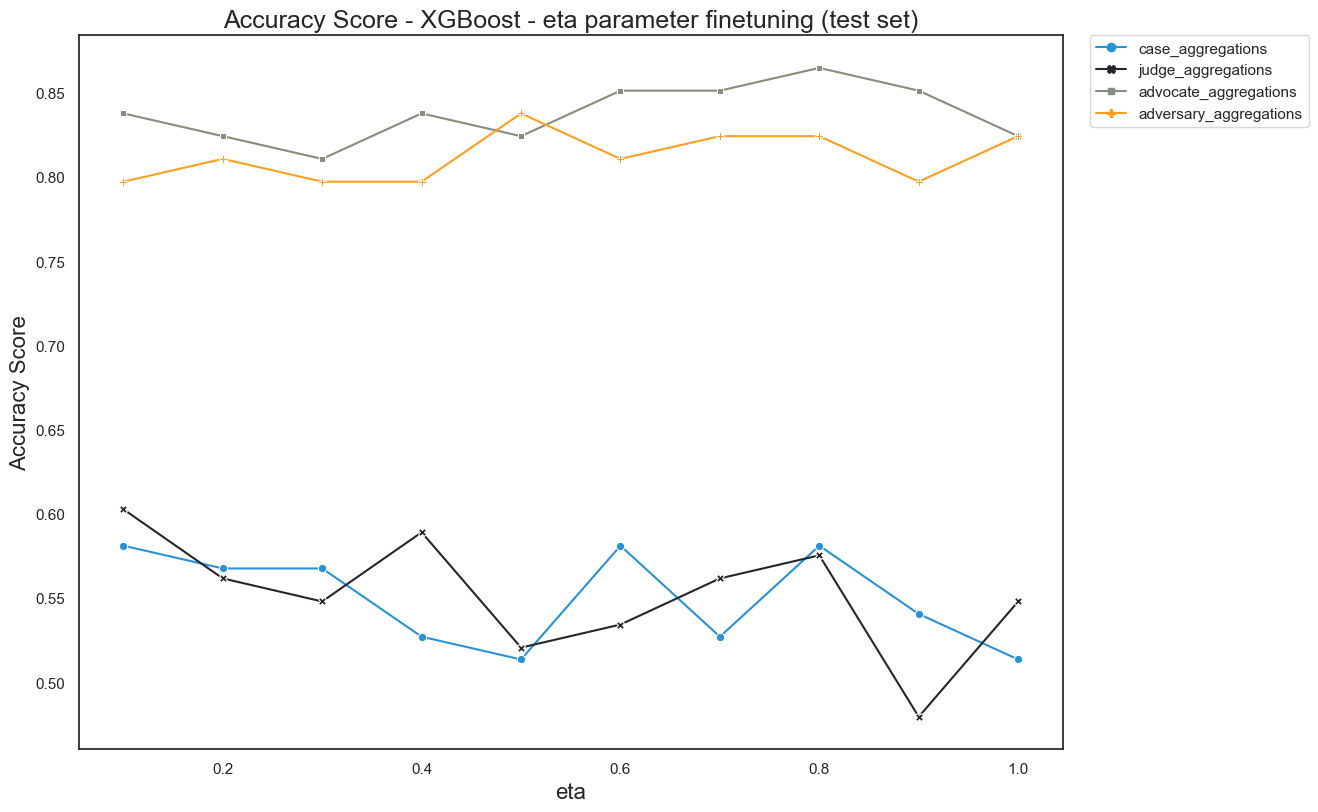

In [60]:
plot_accuracy_scores(eta_melted, eta, xg_label)

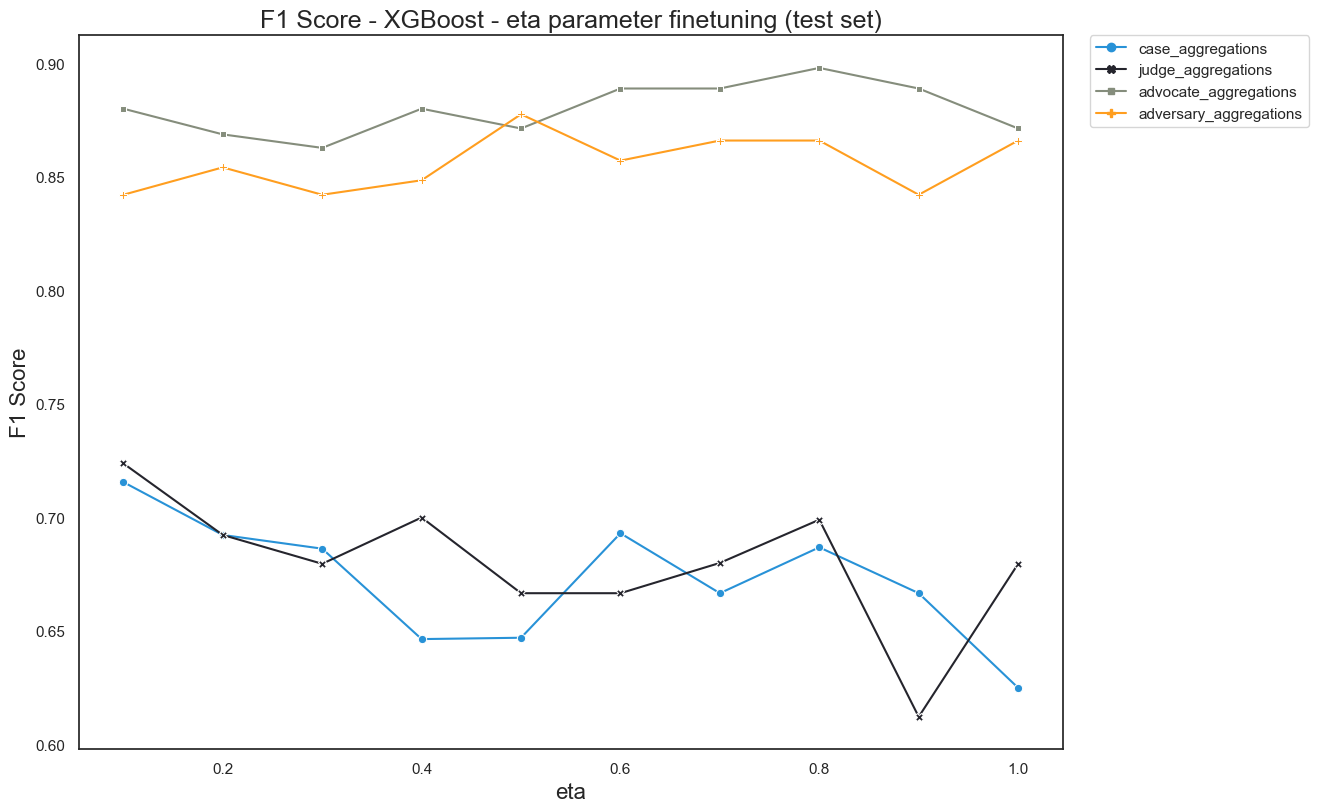

In [61]:
plot_accuracy_scores(eta_f1_melted, eta, xg_label, accuracy_metric="F1")

#### Maximum Tree Depth Finetuning

In [62]:
accuracy_dicts = []
f1_dicts = []
exec_time_dicts = []

for max_depth_value in max_depth_values:
    xgboost_model = XGBoost(debug_mode=False, max_depth=max_depth_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)
    exec_time_dicts.append(xgboost_model.execution_times)

print("Done parameter finetuning for max_depth")

max_depth_melted, max_depth_f1_melted, et_df = get_long_df(
    "Max Tree Depth",
    max_depth_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=exec_time_dicts,
)

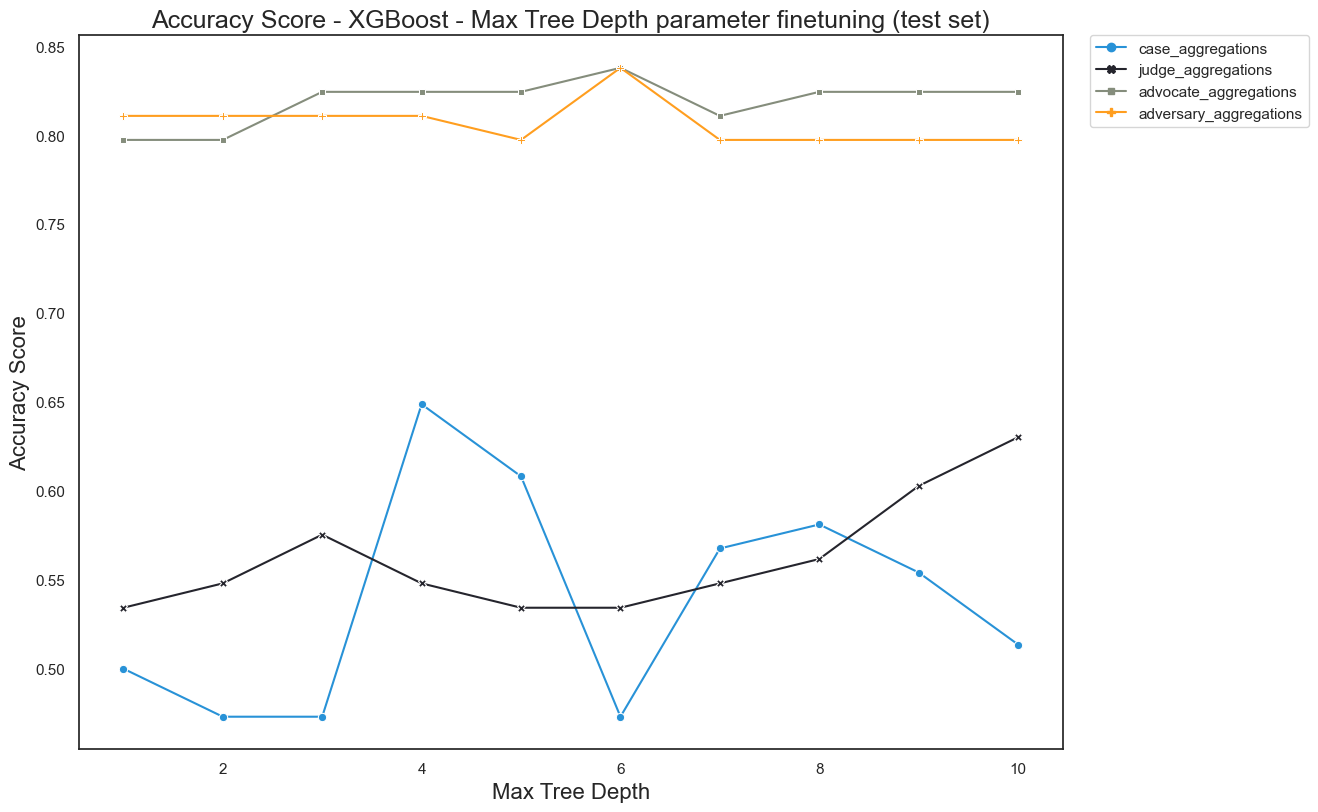

In [ ]:
plot_accuracy_scores(max_depth_melted, maxdepth, xg_label)

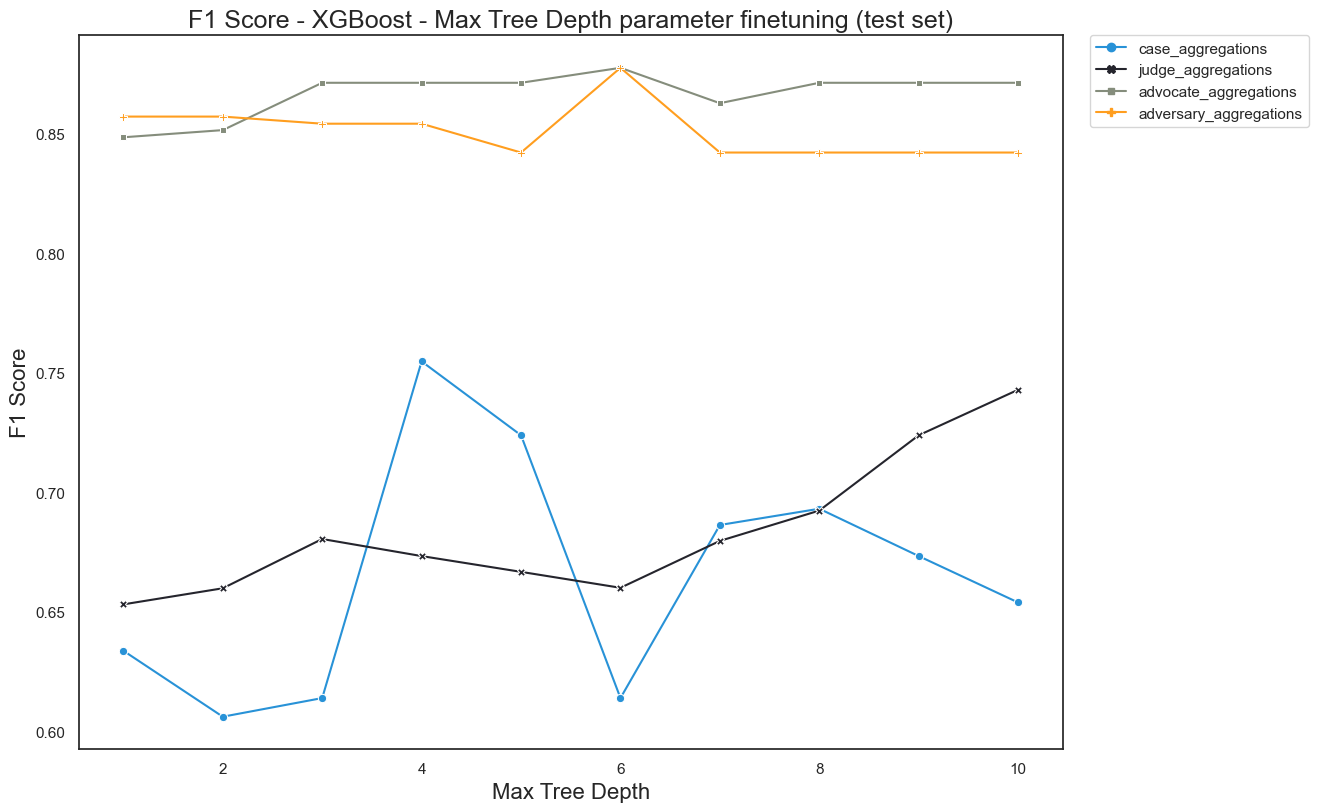

In [ ]:
plot_accuracy_scores(
    max_depth_f1_melted, maxdepth, xg_label, accuracy_metric="F1"
)

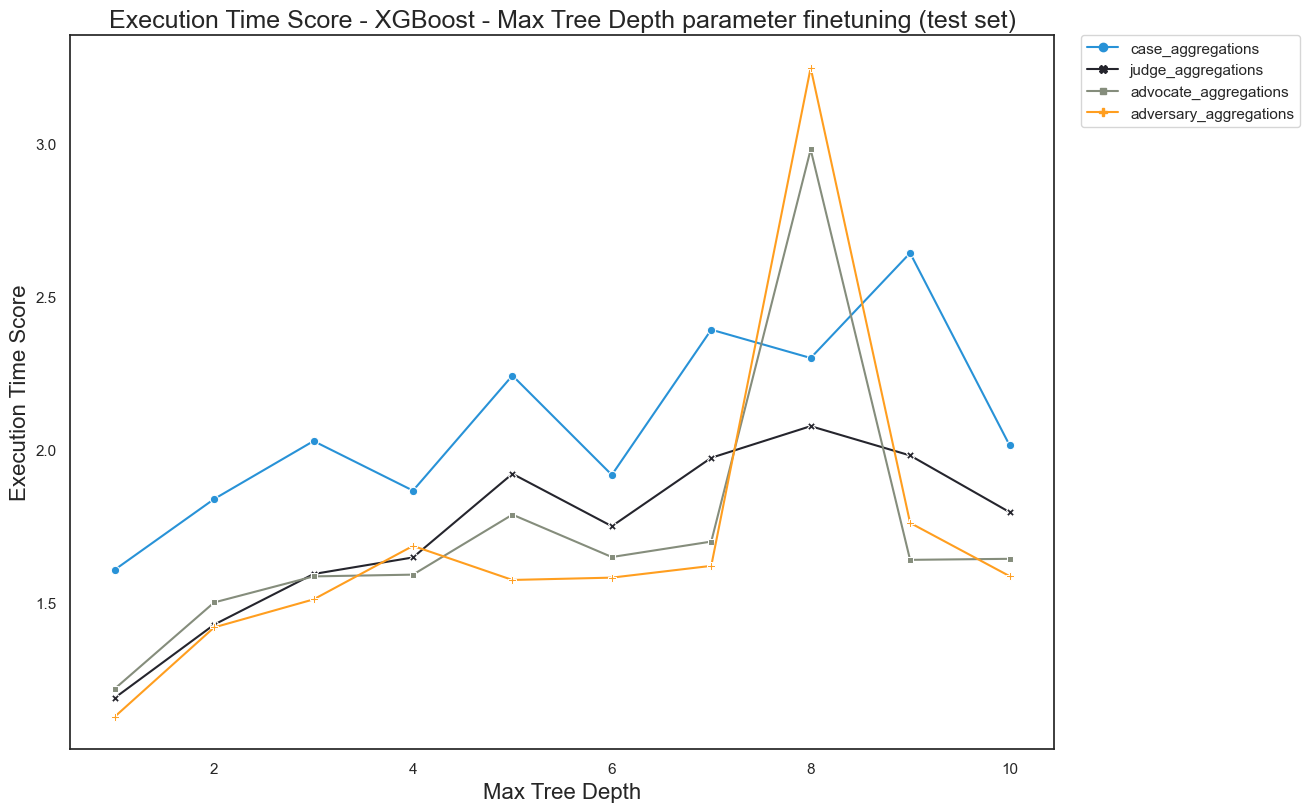

In [ ]:
plot_accuracy_scores(
    et_df, maxdepth, xg_label, accuracy_metric="Execution Time"
)

#### Subsample Finetuning

In [ ]:
accuracy_dicts = []
f1_dicts = []
exec_time_dicts = []

for subsample_value in subsample_values:
    xgboost_model = XGBoost(debug_mode=False, subsample=subsample_value)
    xgboost_model.run()

    accuracy_dicts.append(xgboost_model.accuracies)
    f1_dicts.append(xgboost_model.f1)
    exec_time_dicts.append(xgboost_model.execution_times)

print("Done with subsample finetuning")

subsample_melted, subsample_f1_melted, et_df = get_long_df(
    "Subsample Value",
    subsample_values,
    accuracy_dicts,
    f1_dicts,
    execution_time_dicts=exec_time_dicts,
)

Done with subsample finetuning


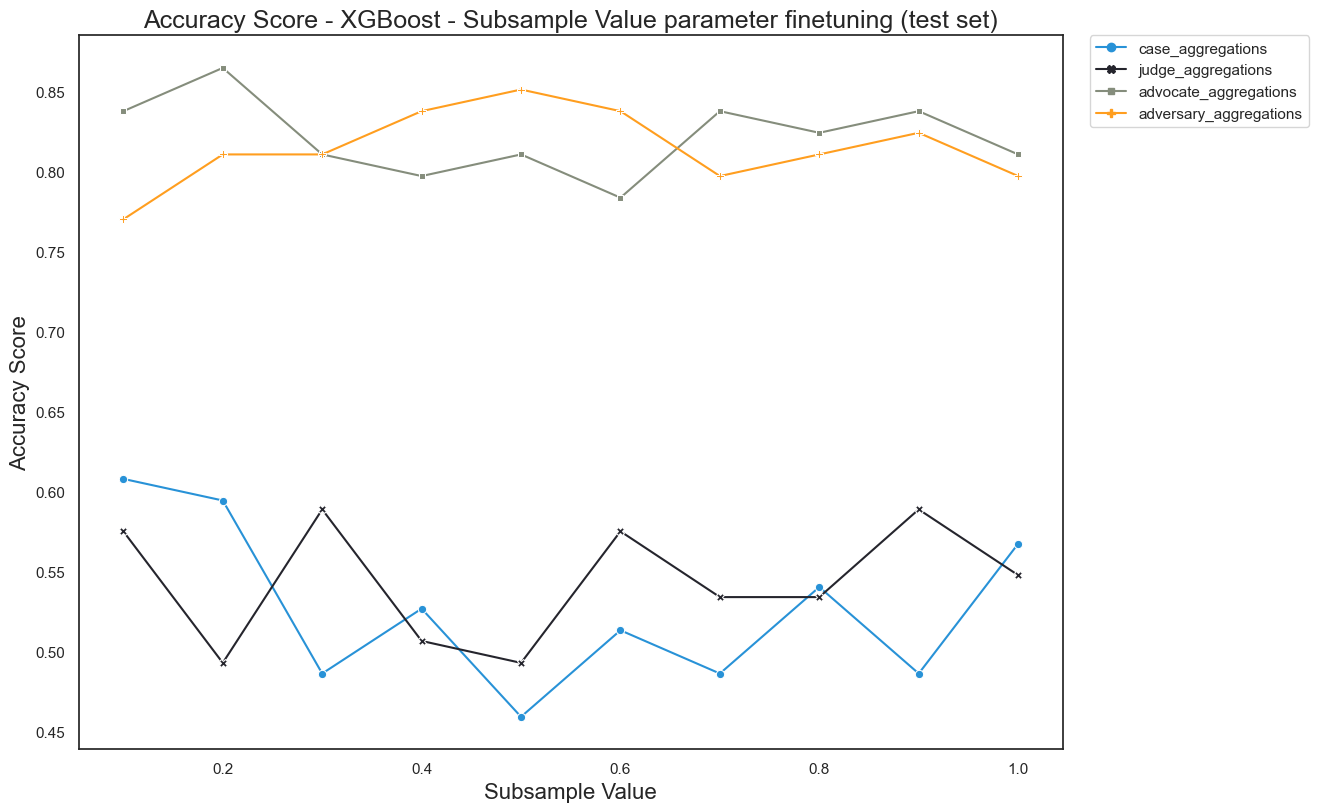

In [ ]:
# Plot accuracy scores
plot_accuracy_scores(subsample_melted, subsamp, xg_label)

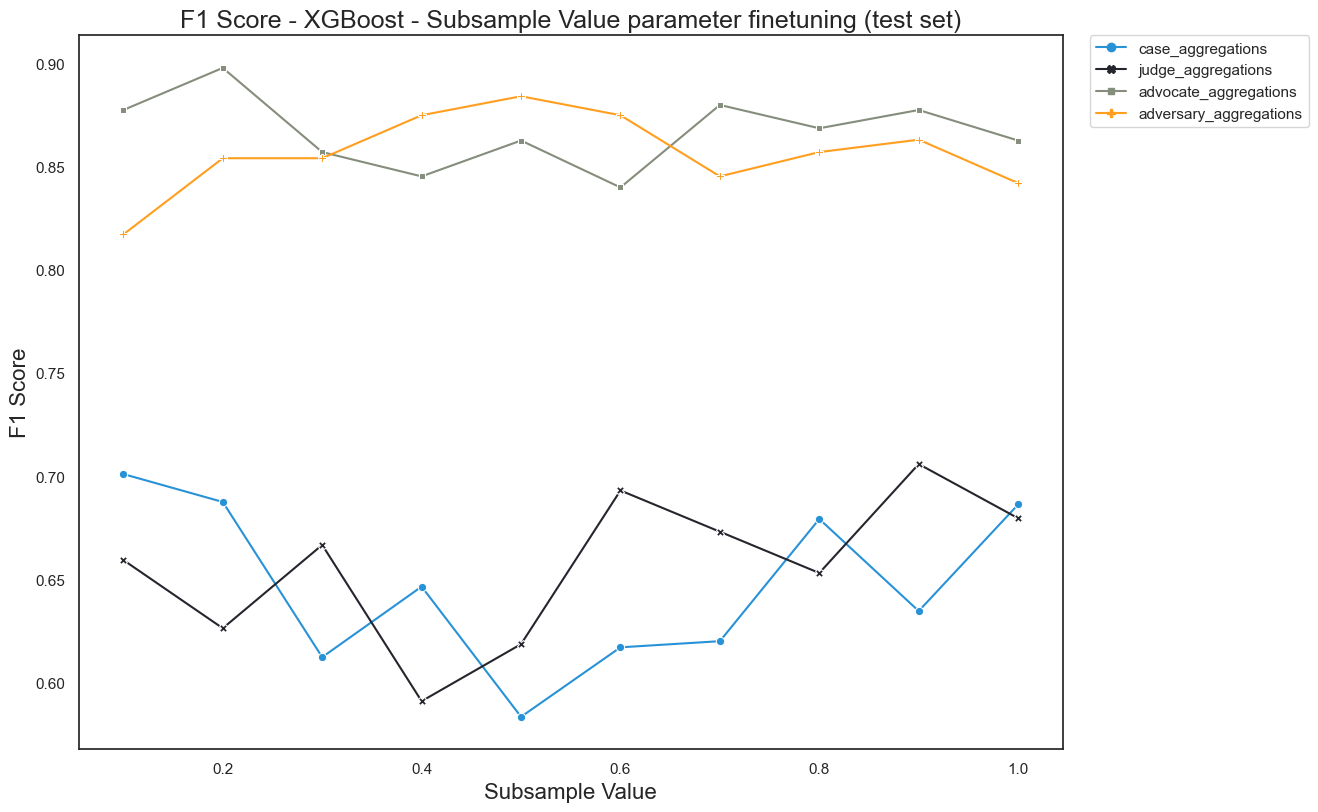

In [ ]:
plot_accuracy_scores(
    subsample_f1_melted, subsamp, xg_label, accuracy_metric="F1"
)

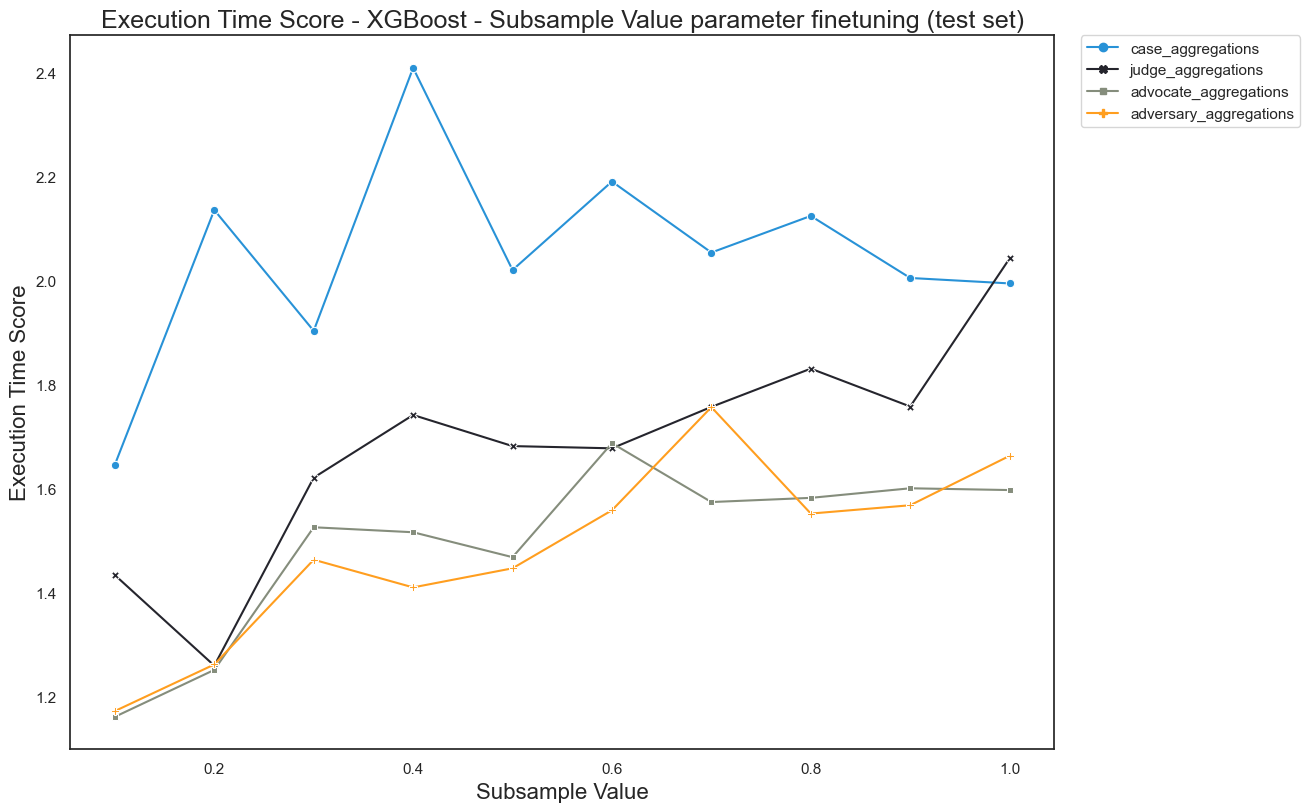

In [ ]:
plot_accuracy_scores(et_df, subsamp, xg_label, accuracy_metric="Execution Time")

## Model Comparisons - Advocate Utterances

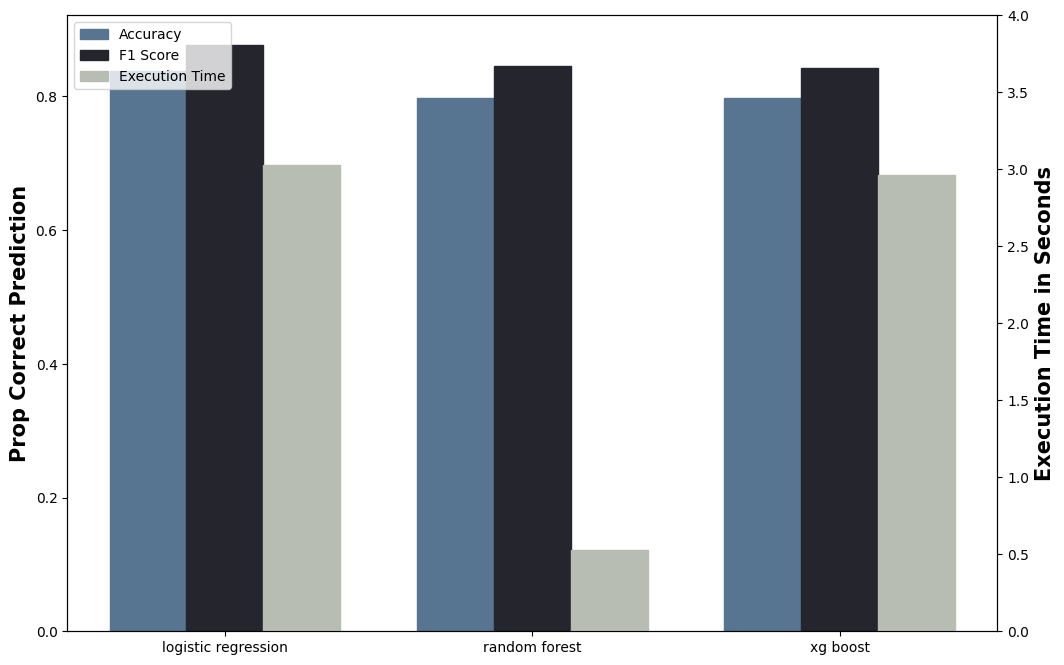

In [ ]:
disp_accuracy(model_comp, labs=model_comp["model"])

#### Simulation
This portion of the project predicts the decision of each judge using the  Logistic Regression, Random Forest, and XGBoost models. And then, based on a majority vote, it predicts the court's decision. As the project requires, duplicate utterances are flattened and combined into one list of utterance tokens. The below shows the real-time prediction for each judge based on training data, accuracies, and F1 scores for each of those judges. Then, based on that training, the model simulates each judge's decision on a case. Using mode, which is the same as the majority decision, we simulate the overall decision of each case. Then, we calculate the accuracy of all the cases. 

As mentioned above, the accuracy of the overall case is useful and can guide relevant stakeholders in their litigation strategies. This simulation, however, also gives insight into how each judge would decide, which from a legal standpoint, may be even more valuable than the overall decision that is somewhat predictable considering the composition of the current court. This modeling could be used to predict justice nominee's voting patterns and their impact on the court.

In [ ]:
Simulation().run()

Logistic Regression information for Judge Anthony M Kennedy
Accuracy: 0.6531365313653137
F1 score: 0.6267928564103314
Logistic Regression information for Judge Antonin Scalia
Accuracy: 0.6531365313653137
F1 score: 0.6267928564103314
Logistic Regression information for Judge Elena Kagan
Accuracy: 0.6531365313653137
F1 score: 0.6267928564103314
Logistic Regression information for Judge John G Roberts Jr
Accuracy: 0.6531365313653137
F1 score: 0.6267928564103314
Logistic Regression information for Judge Ruth Bader Ginsburg
Accuracy: 0.6531365313653137
F1 score: 0.6267928564103314
Logistic Regression information for Judge Samuel A Alito Jr
Accuracy: 0.6531365313653137
F1 score: 0.6267928564103314
Logistic Regression information for Judge Sonia Sotomayor
Accuracy: 0.6531365313653137
F1 score: 0.6267928564103314
Logistic Regression information for Judge Stephen G Breyer
Accuracy: 0.6531365313653137
F1 score: 0.6267928564103314
Logistic Regression information for Judge Clarence Thomas
Accuracy

## Summation

### Summary
The project uses historic United States Supreme Court cases to train natural language processing models to predict case rulings. The project offers insights into the Supreme Court's decision-making process, guiding litigation strategies, informing public curiosity, and facilitating academic research. This project used three models Logistic Regression, XGBoost, and Random Forest. The data was merged into six categories and filtered on 2014 to 2019 data with clear rulings. Advocate and adversary utterances independently contributed more predictive power than combined utterances or judge-only utterances. XGBoost needed careful hyperparameter tuning to avoid overfitting and ensure generalizability to unseen data. These models are limited in capturing complex linguistic relationships, case context, and the letter of the law. Future work would include text vectorization and adding related features such as social context, macroeconomic trends, letter of the law, and precedent information.

**What model worked best for predicting case results based on utterances?** \
Looking at advocate utterances, we found that logistic regression had the highest precision and F1 score. This may be because logistic regression is simple and follows a logit model. If the shown relationship between data and prediction is relatively simple, logistic regression tends to perform better. It is possible that the more complex random forest and XGBoost overfitting from data noise. If the data on the CountVectorizer is sparse, these reasons may contribute to logistic regression outperforming other models.

**If our constraints are time and computing power, which of the three models would be the best to implement?** \
When we take into consideration time complexity and processing power, however, we see that Random Forest actually performed better than the two others. Their F1 score and precision were in the same ball park while it took drastically less time, almost 1/7 or more, for the random forest. One of the reasons for this can be traced back to Random Forest easily parallelized with separate decision trees in each thread while logistic regression cannot be divided into different threads of tasks. The stopping condition for Random Forest can also be faster as there is a maximum depth that is reached compared to a while loop for XGBoost and logistic regression until nothing else can be improved in loss. These are iterative and may take longer to converge. 

### Limitations of the data and project

**Limitations of data:** \
The data lacks critical features such as the letter of the law, precedent information, and supporting documents relevant to each case, a feature that would be essential from the viewpoint of **legal positivism**. The data does not include information about relevant social and cultural contexts that would play a significant role in the case rulings, as pointed out from the perspective of **critical legal studies**. In addition, the project does not have the economic data to consider macroeconomic trends that can influence the rulings, following the **law and economics** school of thought. The data is unbalanced and does not represent all relevant information, so the project is biased in its predictions.

**Limitation of the task:** \
Lawyers often don't care about the outcome itself. Instead, they care often in how one arrives at that conclusion. In addition, the articulation and details in the decision's reasoning are often more critical for the case. As shown above, there are feature limitations that affect the performance of the models. There are also inherent model limitations that restrict this project's prediction capabilities. Logistic regression is limited because it assumes a linear relationship. It worked out well for this test data specifically, but that may be because of the type of data we collected rather than the actual predictive capability. XGBoost and Random Forest are hard to interpret, and both models can lead to overfitting without the correct hyperparameters. Even with the best hyperparameters, we have seen that their overall precision and F1 scores may be worse in data with superficial relationships and overfit to the noise. 

### Future Works
This simulation gives insight into how each judge would decide, which from a legal standpoint, may be even more valuable than the overall and somewhat predictable decision considering the current court's composition. This modeling could be used to predict justice nominee's voting patterns and their impact on the Supreme Court. Future work would include text vectorization and adding related features such as social context, macroeconomic trends, letter of the law, and precedent information.


**What was something you enjoyed and/or learned while working on this project?**

**Federico:** \
I was surprised that we were able to get good results by using bag of words. It was very interesting to see how such a complex task involving language could be solved by using this approach. I also got to see how hyperparameter tuning can make a huge difference in the model's performance, but there are so many possibilities that one should still have some knowledge on which parameters to change and how.

I also learned how ensemble models can be very powerful, but also very hard to interpret. I think this is a tradeoff that one should consider when choosing a model for a specific task.

**Jessup:** \
Compared to manually programming each machine learning model, I learned that using sklearn is drastically easier. This frees up a lot of time to work on optimizing the model through hyperparameters and picking amongst many available models to best fit the different kind of data we are training on. 

**Chanteria:**

**Michael:** \
I most enjoyed being able to craft the multiple parts of this application into fully-functional components. The project has upwards of 10 individually moving parts, and getting those to work in sync was incredibly fun and challenging. I also enjoyed looking for common functions used throughout the application and either abstracting them or putting them in places where they weren't attached to any one class. In short, the project's structure and seeing other team members' technical perspectives brought me the most joy.